In [2]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.models as models
import torch.nn.functional as F
import random
import numpy as np
from tqdm import tqdm

In [3]:
num_epochs = 50

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}

In [6]:
import torchvision.transforms as transforms

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands, patch_size, time=12):
        self.bands = bands
        self.patch_size = patch_size
        self.time = time

    def __call__(self, x):
        return x.view(self.time, self.bands, self.patch_size, self.patch_size).permute(1, 0, 2, 3)

def scale_up_planet_channels(x):
    x[:3] *= 5  # 첫 3개 채널을 5배 스케일링
    return x

def base_transform(bands, patch_size, scale_channels=True):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands, patch_size),  # (12*bands, height, width) → (bands, time, height, width)
        transforms.Lambda(scale_up_planet_channels)  # 첫 3개 채널을 5배 확대
    ])


In [7]:
class ResNetClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=6):
        super(ResNetClassifier, self).__init__()
        # ResNet18 모델을 기반으로 사용
        self.transform = transform
        self.resnet = models.resnet18(weights=None)  # 사전 훈련 없이 초기화
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널 9개로 변경
        self.resnet.maxpool = nn.Identity()  # 5x5 입력이므로 MaxPooling 제거
        self.resnet.fc = nn.Linear(512, num_classes)  # 마지막 출력 뉴런을 클래스 수에 맞게 변경

    def forward(self, x):
        return self.resnet(x)

In [8]:
class ResBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.2):
        super(ResBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

        # 입력과 출력 채널 수가 다르면 1x1 Conv로 맞춤
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.ln = nn.LayerNorm(out_channels)  # LayerNorm 추가

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Dropout 추가
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual  # Residual 연결
        x = self.ln(x.permute(0, 2, 1)).permute(0, 2, 1)  # LayerNorm 적용 (batch, channels, seq)
        x = self.relu(x)
        return x

class ResNet1D(nn.Module):
    def __init__(self, in_channels=9, num_classes=6, dropout=0.2):
        super(ResNet1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)

        self.resblock1 = ResBlock1D(64, 128, dropout=dropout)
        self.resblock2 = ResBlock1D(128, 256, dropout=dropout)
        self.resblock3 = ResBlock1D(256, 512, dropout=dropout)

        self.conv_final = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn_final = nn.BatchNorm1d(512)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)

        x = self.conv_final(x)
        x = self.bn_final(x)
        x = self.relu(x)

        x = self.global_avg_pool(x)
        x = x.squeeze(-1)
        x = self.fc(x)

        return x

In [9]:
import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=9, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        # Linear layer for embedding input_dim -> embed_dim
        self.input_fc = nn.Linear(input_dim, embed_dim)
        
        # Transformer Encoder Layer 설정 (batch_first=True)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  # 입력의 임베딩 차원
            nhead=num_heads,  # Multi-head Attention의 head 개수
            dropout=dropout,
            batch_first=True  # 배치 차원이 첫 번째로 오도록 설정
        )
        
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers  # Encoder Layer의 수
        )
        
        # 마지막 출력에서 분류를 위한 Linear Layer
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # 입력을 임베딩 차원으로 변환
        x = self.input_fc(x)
        
        # Transformer Encoder 통과
        transformer_out = self.transformer_encoder(x)
        
        # transformer_out의 마지막 시퀀스에 해당하는 출력을 가져옵니다.
        # (batch, seq_len, embed_dim) -> (batch, embed_dim)
        out = transformer_out[:, -1, :]
        
        # FC Layer를 통한 분류
        out = self.fc(out)
        
        return out


## Using Bands

In [9]:
bands = 9
patch_size = 1
time_idx = 5 #5월 중순
checkpoints_dir = "./checkpoints/using_bands"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

input.shape = (1,9)

In [10]:
transform = transforms.Compose([base_transform(bands, patch_size), transforms.Lambda(lambda x: x[:,time_idx].squeeze(-1).T)])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
model = ResNet1D(in_channels=1).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 125.72it/s]



Epoch [1/50], Train Loss: 0.9180, Train Accuracy: 61.72%, Val Loss: 0.9021, Val Accuracy: 60.98%



Epoch 2/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 126.45it/s]



Epoch [2/50], Train Loss: 0.8055, Train Accuracy: 66.77%, Val Loss: 0.8929, Val Accuracy: 62.94%



Epoch 3/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 125.87it/s]



Epoch [3/50], Train Loss: 0.7437, Train Accuracy: 69.86%, Val Loss: 0.8808, Val Accuracy: 64.15%



Epoch 4/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 125.88it/s]



Epoch [4/50], Train Loss: 0.7032, Train Accuracy: 71.68%, Val Loss: 0.8409, Val Accuracy: 65.07%



Epoch 5/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 126.03it/s]



Epoch [5/50], Train Loss: 0.6755, Train Accuracy: 72.76%, Val Loss: 0.7734, Val Accuracy: 68.06%



Epoch 6/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 126.58it/s]



Epoch [6/50], Train Loss: 0.6588, Train Accuracy: 73.42%, Val Loss: 0.8033, Val Accuracy: 67.28%



Epoch 7/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 129.00it/s]



Epoch [7/50], Train Loss: 0.6422, Train Accuracy: 74.15%, Val Loss: 0.7755, Val Accuracy: 68.63%



Epoch 8/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 128.40it/s]



Epoch [8/50], Train Loss: 0.6324, Train Accuracy: 74.62%, Val Loss: 0.8170, Val Accuracy: 67.34%



Epoch 9/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:07<00:00, 126.71it/s]



Epoch [9/50], Train Loss: 0.6228, Train Accuracy: 75.07%, Val Loss: 0.7879, Val Accuracy: 67.90%



Epoch 10/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 127.36it/s]



Epoch [10/50], Train Loss: 0.6127, Train Accuracy: 75.45%, Val Loss: 0.8334, Val Accuracy: 66.23%



Epoch 11/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 127.03it/s]



Epoch [11/50], Train Loss: 0.5689, Train Accuracy: 77.24%, Val Loss: 0.7560, Val Accuracy: 69.18%



Epoch 12/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 127.95it/s]



Epoch [12/50], Train Loss: 0.5587, Train Accuracy: 77.80%, Val Loss: 0.7571, Val Accuracy: 69.49%



Epoch 13/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 128.43it/s]



Epoch [13/50], Train Loss: 0.5537, Train Accuracy: 77.92%, Val Loss: 0.7560, Val Accuracy: 69.31%



Epoch 14/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 126.27it/s]



Epoch [14/50], Train Loss: 0.5513, Train Accuracy: 77.92%, Val Loss: 0.7491, Val Accuracy: 69.56%



Epoch 15/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 127.32it/s]



Epoch [15/50], Train Loss: 0.5484, Train Accuracy: 78.13%, Val Loss: 0.7600, Val Accuracy: 69.44%



Epoch 16/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 126.74it/s]



Epoch [16/50], Train Loss: 0.5455, Train Accuracy: 78.15%, Val Loss: 0.7552, Val Accuracy: 69.56%



Epoch 17/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 124.08it/s]



Epoch [17/50], Train Loss: 0.5433, Train Accuracy: 78.32%, Val Loss: 0.7474, Val Accuracy: 69.73%



Epoch 18/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 126.26it/s]



Epoch [18/50], Train Loss: 0.5416, Train Accuracy: 78.31%, Val Loss: 0.7539, Val Accuracy: 69.88%



Epoch 19/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 124.73it/s]



Epoch [19/50], Train Loss: 0.5392, Train Accuracy: 78.48%, Val Loss: 0.7696, Val Accuracy: 69.04%



Epoch 20/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 124.83it/s]



Epoch [20/50], Train Loss: 0.5366, Train Accuracy: 78.53%, Val Loss: 0.7572, Val Accuracy: 69.62%



Epoch 21/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 123.06it/s]



Epoch [21/50], Train Loss: 0.5324, Train Accuracy: 78.84%, Val Loss: 0.7584, Val Accuracy: 69.65%



Epoch 22/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 120.81it/s]



Epoch [22/50], Train Loss: 0.5306, Train Accuracy: 78.81%, Val Loss: 0.7537, Val Accuracy: 69.66%



Epoch 23/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 123.01it/s]



Epoch [23/50], Train Loss: 0.5296, Train Accuracy: 78.77%, Val Loss: 0.7567, Val Accuracy: 69.64%



Epoch 24/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.28it/s]



Epoch [24/50], Train Loss: 0.5312, Train Accuracy: 78.83%, Val Loss: 0.7634, Val Accuracy: 69.38%



Epoch 25/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 119.24it/s]



Epoch [25/50], Train Loss: 0.5290, Train Accuracy: 78.89%, Val Loss: 0.7633, Val Accuracy: 69.49%



Epoch 26/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 124.07it/s]



Epoch [26/50], Train Loss: 0.5275, Train Accuracy: 78.95%, Val Loss: 0.7615, Val Accuracy: 69.45%



Epoch 27/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.06it/s]



Epoch [27/50], Train Loss: 0.5281, Train Accuracy: 78.96%, Val Loss: 0.7529, Val Accuracy: 69.69%



Epoch 28/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 126.43it/s]



Epoch [28/50], Train Loss: 0.5287, Train Accuracy: 78.92%, Val Loss: 0.7516, Val Accuracy: 69.69%



Epoch 29/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 123.88it/s]



Epoch [29/50], Train Loss: 0.5281, Train Accuracy: 78.92%, Val Loss: 0.7513, Val Accuracy: 69.73%



Epoch 30/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.55it/s]



Epoch [30/50], Train Loss: 0.5271, Train Accuracy: 78.94%, Val Loss: 0.7566, Val Accuracy: 69.62%



Epoch 31/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 123.30it/s]



Epoch [31/50], Train Loss: 0.5273, Train Accuracy: 78.94%, Val Loss: 0.7575, Val Accuracy: 69.71%



Epoch 32/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 124.44it/s]



Epoch [32/50], Train Loss: 0.5255, Train Accuracy: 78.99%, Val Loss: 0.7582, Val Accuracy: 69.48%



Epoch 33/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 124.35it/s]



Epoch [33/50], Train Loss: 0.5269, Train Accuracy: 78.99%, Val Loss: 0.7607, Val Accuracy: 69.44%



Epoch 34/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.57it/s]



Epoch [34/50], Train Loss: 0.5270, Train Accuracy: 78.97%, Val Loss: 0.7634, Val Accuracy: 69.41%



Epoch 35/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.65it/s]



Epoch [35/50], Train Loss: 0.5265, Train Accuracy: 78.97%, Val Loss: 0.7655, Val Accuracy: 69.51%



Epoch 36/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.41it/s]



Epoch [36/50], Train Loss: 0.5265, Train Accuracy: 79.00%, Val Loss: 0.7539, Val Accuracy: 69.62%



Epoch 37/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 126.18it/s]



Epoch [37/50], Train Loss: 0.5254, Train Accuracy: 79.10%, Val Loss: 0.7634, Val Accuracy: 69.52%



Epoch 38/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.02it/s]



Epoch [38/50], Train Loss: 0.5278, Train Accuracy: 78.95%, Val Loss: 0.7584, Val Accuracy: 69.57%



Epoch 39/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 121.51it/s]



Epoch [39/50], Train Loss: 0.5257, Train Accuracy: 78.98%, Val Loss: 0.7618, Val Accuracy: 69.52%



Epoch 40/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 126.81it/s]



Epoch [40/50], Train Loss: 0.5256, Train Accuracy: 78.95%, Val Loss: 0.7571, Val Accuracy: 69.53%



Epoch 41/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 125.70it/s]



Epoch [41/50], Train Loss: 0.5268, Train Accuracy: 78.93%, Val Loss: 0.7567, Val Accuracy: 69.63%



Epoch 42/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 127.17it/s]



Epoch [42/50], Train Loss: 0.5257, Train Accuracy: 79.09%, Val Loss: 0.7626, Val Accuracy: 69.48%



Epoch 43/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 124.86it/s]



Epoch [43/50], Train Loss: 0.5264, Train Accuracy: 79.00%, Val Loss: 0.7608, Val Accuracy: 69.54%



Epoch 44/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 122.92it/s]



Epoch [44/50], Train Loss: 0.5264, Train Accuracy: 78.94%, Val Loss: 0.7652, Val Accuracy: 69.44%



Epoch 45/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 118.82it/s]



Epoch [45/50], Train Loss: 0.5252, Train Accuracy: 79.11%, Val Loss: 0.7639, Val Accuracy: 69.49%



Epoch 46/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 122.73it/s]



Epoch [46/50], Train Loss: 0.5265, Train Accuracy: 78.81%, Val Loss: 0.7541, Val Accuracy: 69.67%



Epoch 47/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 121.95it/s]



Epoch [47/50], Train Loss: 0.5254, Train Accuracy: 79.00%, Val Loss: 0.7584, Val Accuracy: 69.65%



Epoch 48/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 121.17it/s]



Epoch [48/50], Train Loss: 0.5259, Train Accuracy: 78.99%, Val Loss: 0.7553, Val Accuracy: 69.67%



Epoch 49/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 120.69it/s]



Epoch [49/50], Train Loss: 0.5256, Train Accuracy: 79.03%, Val Loss: 0.7584, Val Accuracy: 69.55%



Epoch 50/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:07<00:00, 123.76it/s]



Epoch [50/50], Train Loss: 0.5254, Train Accuracy: 78.92%, Val Loss: 0.7596, Val Accuracy: 69.69%


train data


Evaluation Progress: 100%|█████████████████████████████████████████████████| 3796/3796 [00:32<00:00, 116.99it/s]


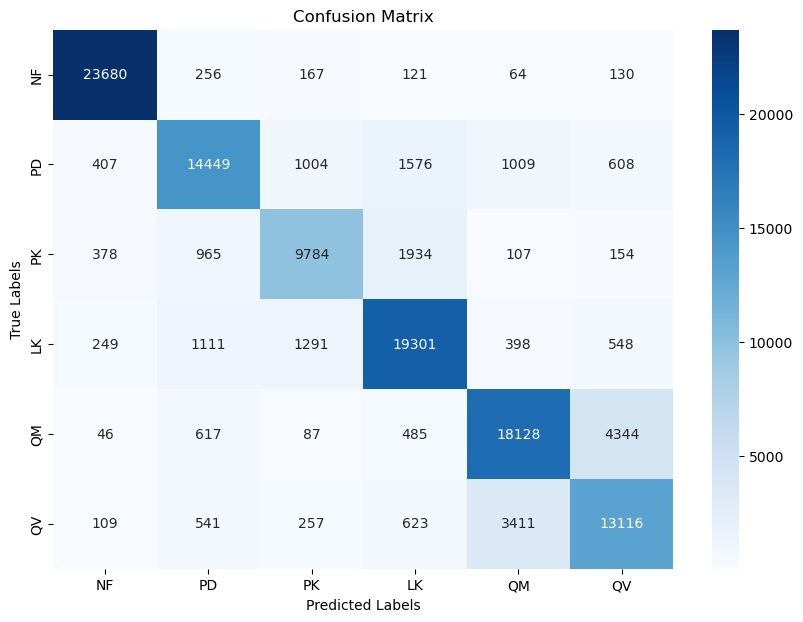

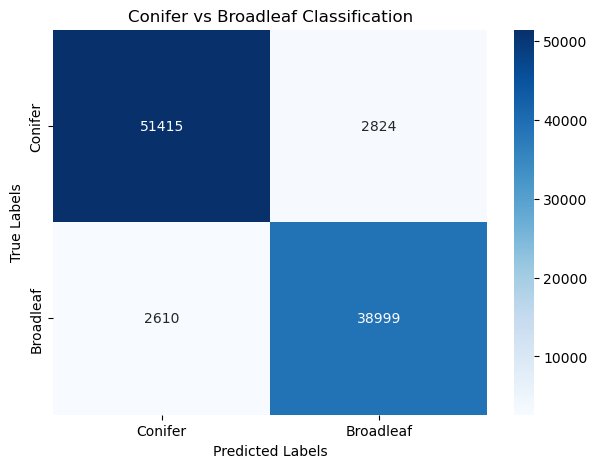

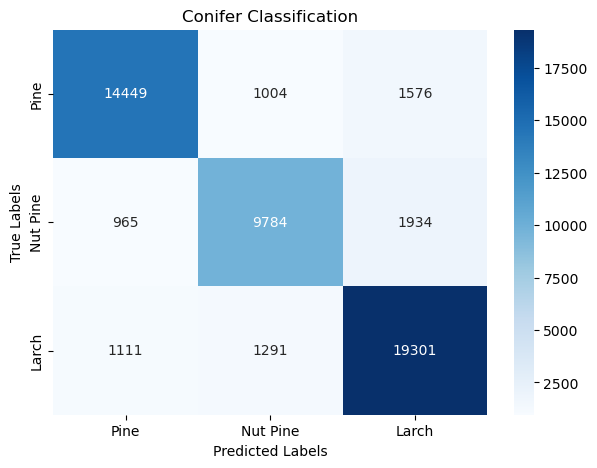

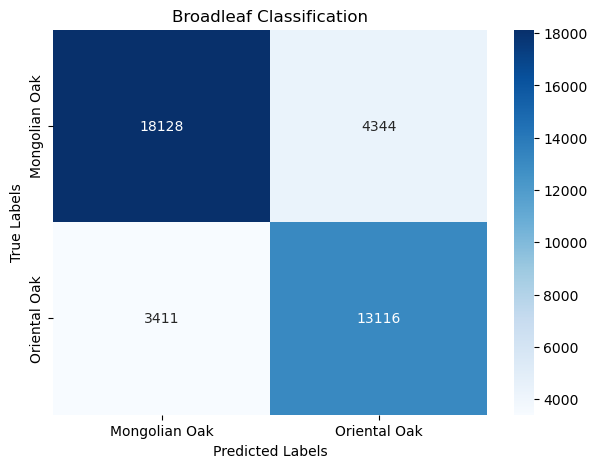


validation data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 940/940 [00:07<00:00, 118.15it/s]


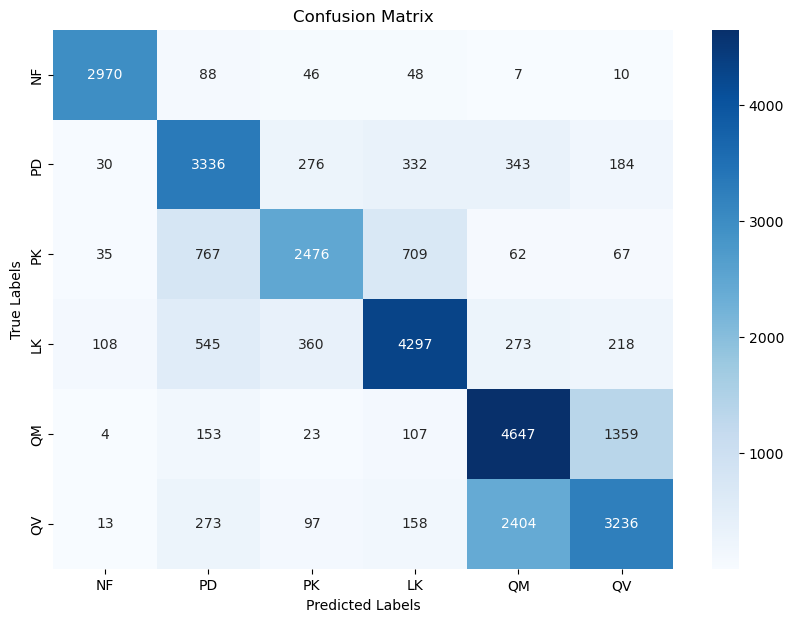

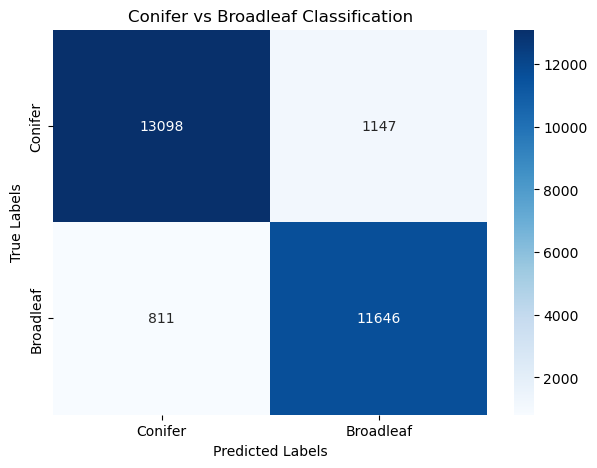

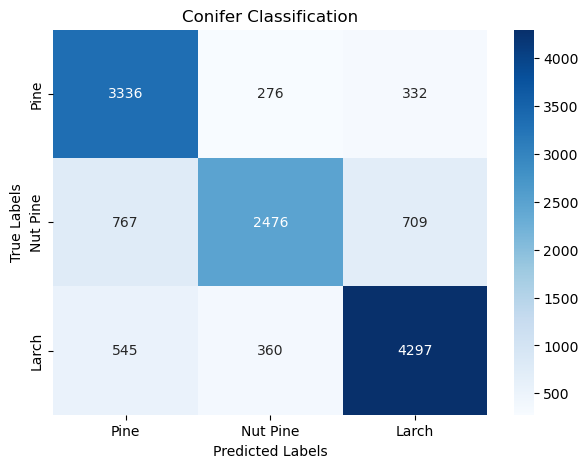

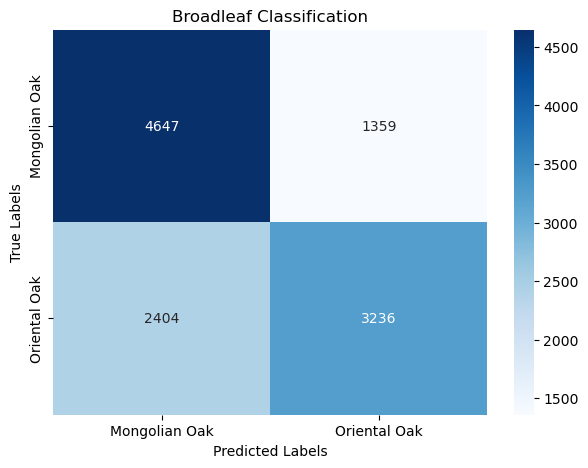

,precision,recall,f1-score,support,Category
NF,0.939873,0.937204,0.938537,3169.000000,Overall
PD,0.646261,0.741169,0.690469,4501.000000,Overall
PK,0.755339,0.601555,0.669732,4116.000000,Overall
LK,0.760396,0.740734,0.750437,5801.000000,Overall
QM,0.600698,0.738440,0.662485,6293.000000,Overall
QV,0.637761,0.523540,0.575033,6181.000000,Overall
accuracy,0.697315,0.697315,0.697315,0.697315,Overall
macro avg,0.723388,0.713774,0.714449,30061.000000,Overall
weighted avg,0.702888,0.697315,0.695759,30061.000000,Overall
Conifer,0.941692,0.919481,0.930454,14245.000000,Conifer vs Broadleaf


In [12]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience=40)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet1d_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [13]:
model = TransformerClassifier(input_dim=9, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=1).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 160.09it/s]



Epoch [1/50], Train Loss: 1.0017, Train Accuracy: 59.13%, Val Loss: 0.9529, Val Accuracy: 60.57%



Epoch 2/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 159.44it/s]



Epoch [2/50], Train Loss: 0.8592, Train Accuracy: 65.66%, Val Loss: 0.9334, Val Accuracy: 60.51%



Epoch 3/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 160.41it/s]



Epoch [3/50], Train Loss: 0.8063, Train Accuracy: 68.08%, Val Loss: 0.9333, Val Accuracy: 62.17%



Epoch 4/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 162.20it/s]



Epoch [4/50], Train Loss: 0.7734, Train Accuracy: 69.42%, Val Loss: 0.9083, Val Accuracy: 62.31%



Epoch 5/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 161.64it/s]



Epoch [5/50], Train Loss: 0.7508, Train Accuracy: 70.39%, Val Loss: 0.9108, Val Accuracy: 63.37%



Epoch 6/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 162.60it/s]



Epoch [6/50], Train Loss: 0.7367, Train Accuracy: 70.99%, Val Loss: 0.8573, Val Accuracy: 65.03%



Epoch 7/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 160.58it/s]



Epoch [7/50], Train Loss: 0.7236, Train Accuracy: 71.59%, Val Loss: 0.8853, Val Accuracy: 63.99%



Epoch 8/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 160.71it/s]



Epoch [8/50], Train Loss: 0.7102, Train Accuracy: 72.11%, Val Loss: 0.9075, Val Accuracy: 63.11%



Epoch 9/50 - Validation: 100%|███████████████████████████████████████████████| 940/940 [00:05<00:00, 160.41it/s]



Epoch [9/50], Train Loss: 0.7038, Train Accuracy: 72.36%, Val Loss: 0.8491, Val Accuracy: 65.12%



Epoch 10/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.52it/s]



Epoch [10/50], Train Loss: 0.6949, Train Accuracy: 72.88%, Val Loss: 0.8475, Val Accuracy: 65.56%



Epoch 11/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.69it/s]



Epoch [11/50], Train Loss: 0.6200, Train Accuracy: 75.99%, Val Loss: 0.8523, Val Accuracy: 65.79%



Epoch 12/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.18it/s]



Epoch [12/50], Train Loss: 0.6092, Train Accuracy: 76.25%, Val Loss: 0.8995, Val Accuracy: 64.76%



Epoch 13/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.05it/s]



Epoch [13/50], Train Loss: 0.6043, Train Accuracy: 76.36%, Val Loss: 0.8578, Val Accuracy: 66.08%



Epoch 14/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.55it/s]



Epoch [14/50], Train Loss: 0.6005, Train Accuracy: 76.65%, Val Loss: 0.8206, Val Accuracy: 67.41%



Epoch 15/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.49it/s]



Epoch [15/50], Train Loss: 0.5985, Train Accuracy: 76.69%, Val Loss: 0.8353, Val Accuracy: 66.93%



Epoch 16/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.97it/s]



Epoch [16/50], Train Loss: 0.5953, Train Accuracy: 76.81%, Val Loss: 0.8443, Val Accuracy: 66.68%



Epoch 17/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.99it/s]



Epoch [17/50], Train Loss: 0.5934, Train Accuracy: 76.74%, Val Loss: 0.8395, Val Accuracy: 66.77%



Epoch 18/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 158.71it/s]



Epoch [18/50], Train Loss: 0.5929, Train Accuracy: 76.94%, Val Loss: 0.8374, Val Accuracy: 66.67%



Epoch 19/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 158.62it/s]



Epoch [19/50], Train Loss: 0.5895, Train Accuracy: 77.08%, Val Loss: 0.8255, Val Accuracy: 67.41%



Epoch 20/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.35it/s]



Epoch [20/50], Train Loss: 0.5876, Train Accuracy: 77.11%, Val Loss: 0.8473, Val Accuracy: 66.80%



Epoch 21/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.06it/s]



Epoch [21/50], Train Loss: 0.5771, Train Accuracy: 77.46%, Val Loss: 0.8409, Val Accuracy: 67.04%



Epoch 22/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 159.69it/s]



Epoch [22/50], Train Loss: 0.5756, Train Accuracy: 77.54%, Val Loss: 0.8466, Val Accuracy: 66.85%



Epoch 23/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.67it/s]



Epoch [23/50], Train Loss: 0.5763, Train Accuracy: 77.63%, Val Loss: 0.8500, Val Accuracy: 66.59%



Epoch 24/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.88it/s]



Epoch [24/50], Train Loss: 0.5755, Train Accuracy: 77.57%, Val Loss: 0.8415, Val Accuracy: 67.05%



Epoch 25/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.40it/s]



Epoch [25/50], Train Loss: 0.5755, Train Accuracy: 77.49%, Val Loss: 0.8412, Val Accuracy: 67.14%



Epoch 26/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.83it/s]



Epoch [26/50], Train Loss: 0.5749, Train Accuracy: 77.57%, Val Loss: 0.8425, Val Accuracy: 67.05%



Epoch 27/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.53it/s]



Epoch [27/50], Train Loss: 0.5747, Train Accuracy: 77.60%, Val Loss: 0.8403, Val Accuracy: 67.10%



Epoch 28/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.15it/s]



Epoch [28/50], Train Loss: 0.5740, Train Accuracy: 77.68%, Val Loss: 0.8582, Val Accuracy: 66.46%



Epoch 29/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 165.06it/s]



Epoch [29/50], Train Loss: 0.5743, Train Accuracy: 77.55%, Val Loss: 0.8567, Val Accuracy: 66.46%



Epoch 30/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.54it/s]



Epoch [30/50], Train Loss: 0.5744, Train Accuracy: 77.62%, Val Loss: 0.8496, Val Accuracy: 66.77%



Epoch 31/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.77it/s]



Epoch [31/50], Train Loss: 0.5725, Train Accuracy: 77.80%, Val Loss: 0.8448, Val Accuracy: 66.93%



Epoch 32/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.97it/s]



Epoch [32/50], Train Loss: 0.5719, Train Accuracy: 77.61%, Val Loss: 0.8485, Val Accuracy: 66.84%



Epoch 33/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 163.24it/s]



Epoch [33/50], Train Loss: 0.5744, Train Accuracy: 77.65%, Val Loss: 0.8487, Val Accuracy: 66.88%



Epoch 34/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.26it/s]



Epoch [34/50], Train Loss: 0.5728, Train Accuracy: 77.64%, Val Loss: 0.8474, Val Accuracy: 66.87%



Epoch 35/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.91it/s]



Epoch [35/50], Train Loss: 0.5738, Train Accuracy: 77.72%, Val Loss: 0.8482, Val Accuracy: 66.87%



Epoch 36/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.01it/s]



Epoch [36/50], Train Loss: 0.5729, Train Accuracy: 77.64%, Val Loss: 0.8493, Val Accuracy: 66.81%



Epoch 37/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.46it/s]



Epoch [37/50], Train Loss: 0.5750, Train Accuracy: 77.51%, Val Loss: 0.8482, Val Accuracy: 66.86%



Epoch 38/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 162.68it/s]



Epoch [38/50], Train Loss: 0.5732, Train Accuracy: 77.70%, Val Loss: 0.8488, Val Accuracy: 66.87%



Epoch 39/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.55it/s]



Epoch [39/50], Train Loss: 0.5732, Train Accuracy: 77.60%, Val Loss: 0.8436, Val Accuracy: 67.03%



Epoch 40/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.68it/s]



Epoch [40/50], Train Loss: 0.5729, Train Accuracy: 77.69%, Val Loss: 0.8454, Val Accuracy: 66.96%



Epoch 41/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.48it/s]



Epoch [41/50], Train Loss: 0.5732, Train Accuracy: 77.78%, Val Loss: 0.8462, Val Accuracy: 66.94%



Epoch 42/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.85it/s]



Epoch [42/50], Train Loss: 0.5731, Train Accuracy: 77.68%, Val Loss: 0.8472, Val Accuracy: 66.92%



Epoch 43/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.94it/s]



Epoch [43/50], Train Loss: 0.5721, Train Accuracy: 77.62%, Val Loss: 0.8467, Val Accuracy: 66.90%



Epoch 44/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.27it/s]



Epoch [44/50], Train Loss: 0.5727, Train Accuracy: 77.68%, Val Loss: 0.8472, Val Accuracy: 66.88%



Epoch 45/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 158.74it/s]



Epoch [45/50], Train Loss: 0.5725, Train Accuracy: 77.70%, Val Loss: 0.8467, Val Accuracy: 66.90%



Epoch 46/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.33it/s]



Epoch [46/50], Train Loss: 0.5734, Train Accuracy: 77.56%, Val Loss: 0.8466, Val Accuracy: 66.90%



Epoch 47/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 160.46it/s]



Epoch [47/50], Train Loss: 0.5723, Train Accuracy: 77.66%, Val Loss: 0.8471, Val Accuracy: 66.90%



Epoch 48/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 159.53it/s]



Epoch [48/50], Train Loss: 0.5724, Train Accuracy: 77.74%, Val Loss: 0.8470, Val Accuracy: 66.90%



Epoch 49/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.19it/s]



Epoch [49/50], Train Loss: 0.5718, Train Accuracy: 77.74%, Val Loss: 0.8472, Val Accuracy: 66.91%



Epoch 50/50 - Validation: 100%|██████████████████████████████████████████████| 940/940 [00:05<00:00, 161.57it/s]



Epoch [50/50], Train Loss: 0.5718, Train Accuracy: 77.68%, Val Loss: 0.8469, Val Accuracy: 66.90%


train data


Evaluation Progress: 100%|█████████████████████████████████████████████████| 3796/3796 [00:23<00:00, 160.52it/s]


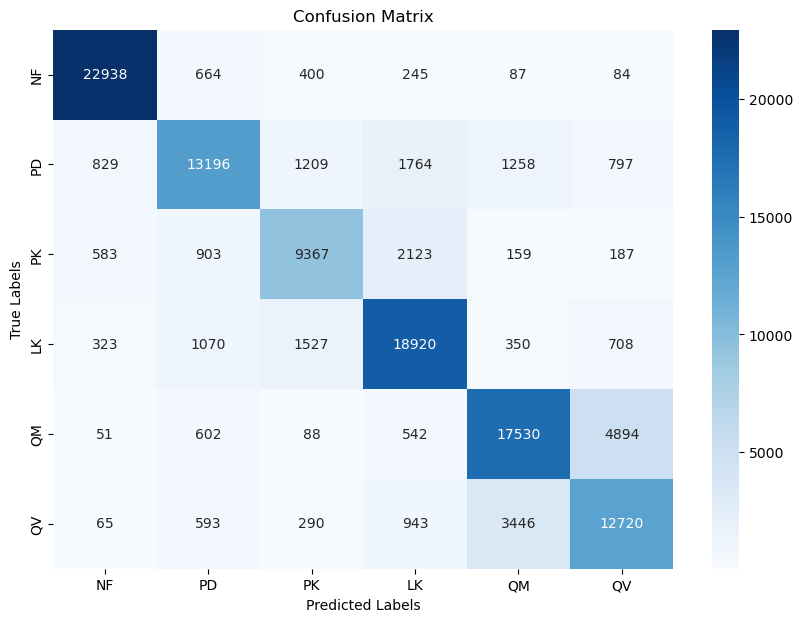

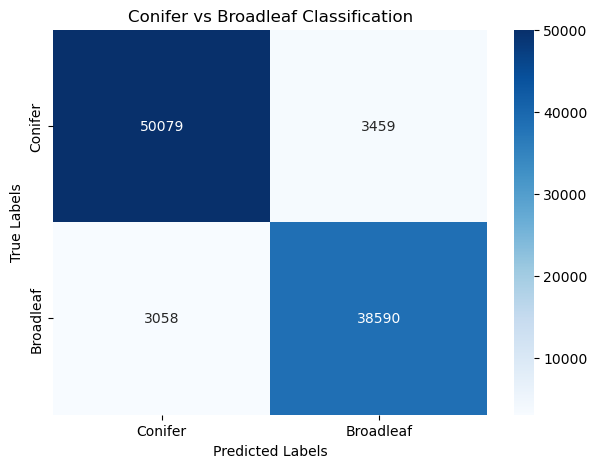

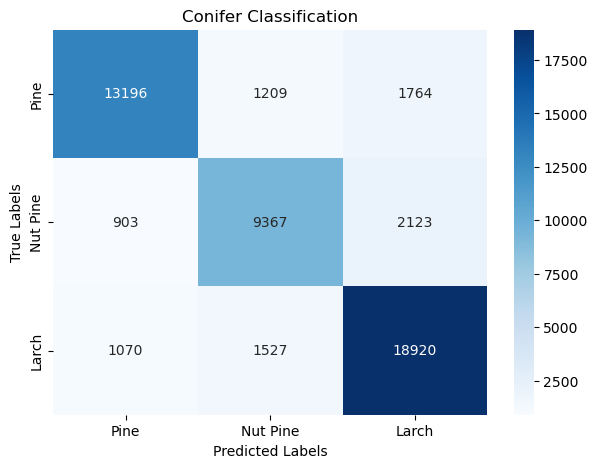

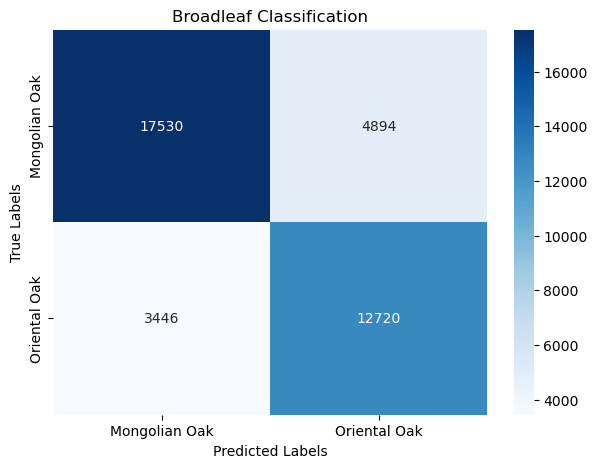


validation data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 940/940 [00:05<00:00, 162.26it/s]


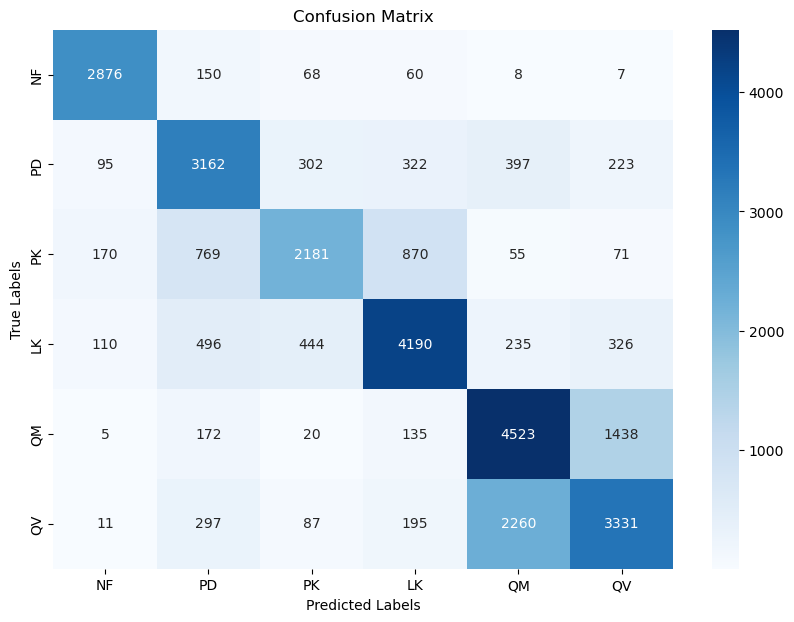

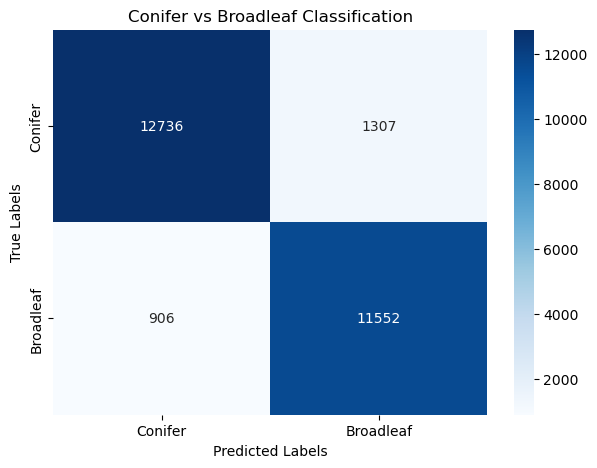

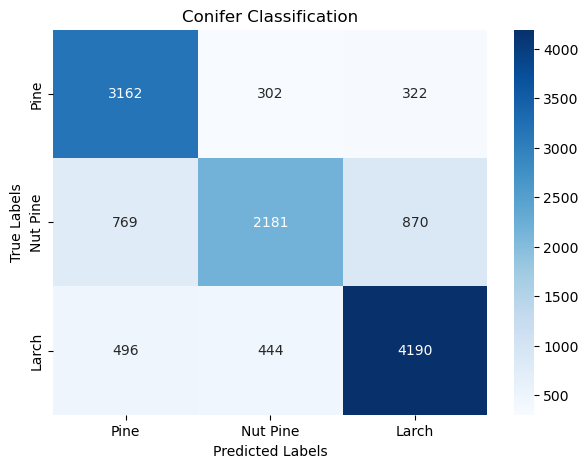

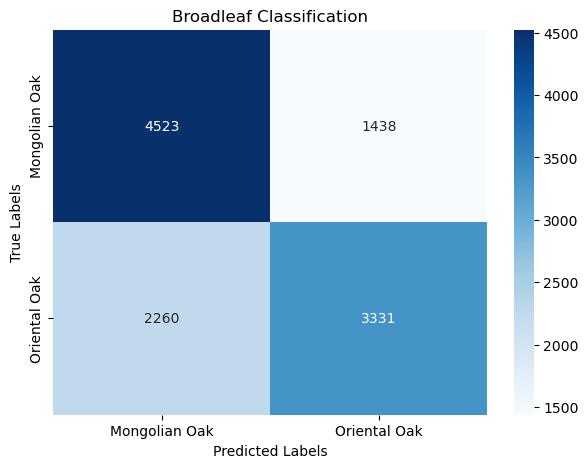

,precision,recall,f1-score,support,Category
NF,0.880318,0.907542,0.893723,3169.000000,Overall
PD,0.626635,0.702511,0.662407,4501.000000,Overall
PK,0.703095,0.529883,0.604323,4116.000000,Overall
LK,0.725918,0.722289,0.724099,5801.000000,Overall
QM,0.604841,0.718735,0.656888,6293.000000,Overall
QV,0.617309,0.538910,0.575451,6181.000000,Overall
accuracy,0.674063,0.674063,0.674063,0.674063,Overall
macro avg,0.693019,0.686645,0.686148,30061.000000,Overall
weighted avg,0.676526,0.674063,0.671709,30061.000000,Overall
Conifer,0.933587,0.906929,0.920065,14043.000000,Conifer vs Broadleaf


In [14]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience=40)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"trasformer_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [15]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

## Using Bands, Space

In [10]:
bands = 9
patch_size = 9
time_idx = 5 #5월 중순
checkpoints_dir = "./checkpoints/using_bands_space"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [11]:
transform = transforms.Compose([base_transform(bands, patch_size), transforms.Lambda(lambda x: x[:,time_idx])])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
model = ResNetClassifier(in_channels=9).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1/50 - Validation: 100%|███████████████████████████████| 936/936 [00:10<00:00, 92.61it/s]



Epoch [1/50], Train Loss: 0.7467, Train Accuracy: 70.41%, Val Loss: 0.9491, Val Accuracy: 61.62%



Epoch 2/50 - Validation: 100%|███████████████████████████████| 936/936 [00:09<00:00, 94.33it/s]



Epoch [2/50], Train Loss: 0.5929, Train Accuracy: 76.83%, Val Loss: 0.9073, Val Accuracy: 64.77%



Epoch 3/50 - Validation: 100%|███████████████████████████████| 936/936 [00:09<00:00, 93.72it/s]



Epoch [3/50], Train Loss: 0.5353, Train Accuracy: 79.26%, Val Loss: 1.9995, Val Accuracy: 47.89%



Epoch 4/50 - Validation: 100%|███████████████████████████████| 936/936 [00:09<00:00, 93.85it/s]



Epoch [4/50], Train Loss: 0.4907, Train Accuracy: 80.77%, Val Loss: 0.8221, Val Accuracy: 68.30%



Epoch 5/50 - Validation: 100%|███████████████████████████████| 936/936 [00:10<00:00, 91.27it/s]



Epoch [5/50], Train Loss: 0.4595, Train Accuracy: 81.98%, Val Loss: 0.7630, Val Accuracy: 71.50%



Epoch 6/50 - Validation: 100%|███████████████████████████████| 936/936 [00:10<00:00, 92.76it/s]



Epoch [6/50], Train Loss: 0.4273, Train Accuracy: 83.21%, Val Loss: 0.9059, Val Accuracy: 69.69%



Epoch 7/50 - Validation: 100%|███████████████████████████████| 936/936 [00:09<00:00, 94.10it/s]



Epoch [7/50], Train Loss: 0.4039, Train Accuracy: 83.98%, Val Loss: 0.6847, Val Accuracy: 73.46%



Epoch 8/50 - Validation: 100%|███████████████████████████████| 936/936 [00:09<00:00, 94.20it/s]



Epoch [8/50], Train Loss: 0.3808, Train Accuracy: 85.03%, Val Loss: 0.8759, Val Accuracy: 69.18%



Epoch 9/50 - Validation: 100%|███████████████████████████████| 936/936 [00:10<00:00, 92.72it/s]



Epoch [9/50], Train Loss: 0.3582, Train Accuracy: 85.77%, Val Loss: 1.1134, Val Accuracy: 64.85%



Epoch 10/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.67it/s]



Epoch [10/50], Train Loss: 0.3383, Train Accuracy: 86.63%, Val Loss: 1.0795, Val Accuracy: 65.95%



Epoch 11/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.24it/s]



Epoch [11/50], Train Loss: 0.2549, Train Accuracy: 89.93%, Val Loss: 0.7963, Val Accuracy: 74.91%



Epoch 12/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.33it/s]



Epoch [12/50], Train Loss: 0.2356, Train Accuracy: 90.66%, Val Loss: 0.8058, Val Accuracy: 74.50%



Epoch 13/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 93.66it/s]



Epoch [13/50], Train Loss: 0.2247, Train Accuracy: 91.01%, Val Loss: 0.8388, Val Accuracy: 74.21%



Epoch 14/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.26it/s]



Epoch [14/50], Train Loss: 0.2159, Train Accuracy: 91.38%, Val Loss: 0.8895, Val Accuracy: 74.17%



Epoch 15/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.84it/s]



Epoch [15/50], Train Loss: 0.2059, Train Accuracy: 91.82%, Val Loss: 0.8802, Val Accuracy: 74.01%



Epoch 16/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.49it/s]



Epoch [16/50], Train Loss: 0.2001, Train Accuracy: 92.04%, Val Loss: 0.9203, Val Accuracy: 74.67%



Epoch 17/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.28it/s]



Epoch [17/50], Train Loss: 0.1918, Train Accuracy: 92.39%, Val Loss: 0.9388, Val Accuracy: 74.05%



Epoch 18/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.30it/s]



Epoch [18/50], Train Loss: 0.1863, Train Accuracy: 92.53%, Val Loss: 0.9528, Val Accuracy: 74.36%



Epoch 19/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.34it/s]



Epoch [19/50], Train Loss: 0.1820, Train Accuracy: 92.74%, Val Loss: 0.9735, Val Accuracy: 73.92%



Epoch 20/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.77it/s]



Epoch [20/50], Train Loss: 0.1733, Train Accuracy: 93.12%, Val Loss: 1.0526, Val Accuracy: 73.16%



Epoch 21/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.25it/s]



Epoch [21/50], Train Loss: 0.1609, Train Accuracy: 93.65%, Val Loss: 0.9836, Val Accuracy: 74.20%



Epoch 22/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.43it/s]



Epoch [22/50], Train Loss: 0.1561, Train Accuracy: 93.85%, Val Loss: 0.9917, Val Accuracy: 74.31%



Epoch 23/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.10it/s]



Epoch [23/50], Train Loss: 0.1575, Train Accuracy: 93.77%, Val Loss: 1.0070, Val Accuracy: 74.14%



Epoch 24/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.33it/s]



Epoch [24/50], Train Loss: 0.1558, Train Accuracy: 93.76%, Val Loss: 0.9992, Val Accuracy: 74.62%



Epoch 25/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.86it/s]



Epoch [25/50], Train Loss: 0.1526, Train Accuracy: 93.98%, Val Loss: 1.0032, Val Accuracy: 74.23%



Epoch 26/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.05it/s]



Epoch [26/50], Train Loss: 0.1516, Train Accuracy: 93.99%, Val Loss: 1.0167, Val Accuracy: 74.28%



Epoch 27/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.93it/s]



Epoch [27/50], Train Loss: 0.1514, Train Accuracy: 94.02%, Val Loss: 1.0568, Val Accuracy: 73.85%



Epoch 28/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.34it/s]



Epoch [28/50], Train Loss: 0.1509, Train Accuracy: 94.03%, Val Loss: 1.0195, Val Accuracy: 74.26%



Epoch 29/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.64it/s]



Epoch [29/50], Train Loss: 0.1517, Train Accuracy: 93.93%, Val Loss: 1.0325, Val Accuracy: 74.31%



Epoch 30/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.81it/s]



Epoch [30/50], Train Loss: 0.1498, Train Accuracy: 94.06%, Val Loss: 1.0287, Val Accuracy: 74.24%



Epoch 31/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.32it/s]



Epoch [31/50], Train Loss: 0.1477, Train Accuracy: 94.23%, Val Loss: 1.0319, Val Accuracy: 74.09%



Epoch 32/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.71it/s]



Epoch [32/50], Train Loss: 0.1475, Train Accuracy: 94.16%, Val Loss: 1.0207, Val Accuracy: 74.35%



Epoch 33/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.72it/s]



Epoch [33/50], Train Loss: 0.1488, Train Accuracy: 94.12%, Val Loss: 1.0322, Val Accuracy: 74.15%



Epoch 34/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.23it/s]



Epoch [34/50], Train Loss: 0.1488, Train Accuracy: 94.13%, Val Loss: 1.0476, Val Accuracy: 74.14%



Epoch 35/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.51it/s]



Epoch [35/50], Train Loss: 0.1480, Train Accuracy: 94.23%, Val Loss: 1.0192, Val Accuracy: 74.38%



Epoch 36/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.47it/s]



Epoch [36/50], Train Loss: 0.1464, Train Accuracy: 94.22%, Val Loss: 1.0182, Val Accuracy: 74.06%



Epoch 37/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.83it/s]



Epoch [37/50], Train Loss: 0.1459, Train Accuracy: 94.23%, Val Loss: 1.0586, Val Accuracy: 73.88%



Epoch 38/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.82it/s]



Epoch [38/50], Train Loss: 0.1472, Train Accuracy: 94.21%, Val Loss: 1.0536, Val Accuracy: 74.09%



Epoch 39/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.64it/s]



Epoch [39/50], Train Loss: 0.1466, Train Accuracy: 94.21%, Val Loss: 1.0318, Val Accuracy: 74.30%



Epoch 40/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.71it/s]



Epoch [40/50], Train Loss: 0.1471, Train Accuracy: 94.15%, Val Loss: 1.0189, Val Accuracy: 74.31%



Epoch 41/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.72it/s]



Epoch [41/50], Train Loss: 0.1455, Train Accuracy: 94.28%, Val Loss: 1.0529, Val Accuracy: 74.05%



Epoch 42/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.53it/s]



Epoch [42/50], Train Loss: 0.1448, Train Accuracy: 94.30%, Val Loss: 1.0537, Val Accuracy: 74.08%



Epoch 43/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.43it/s]



Epoch [43/50], Train Loss: 0.1475, Train Accuracy: 94.20%, Val Loss: 1.0621, Val Accuracy: 74.07%



Epoch 44/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 96.56it/s]



Epoch [44/50], Train Loss: 0.1464, Train Accuracy: 94.24%, Val Loss: 1.0369, Val Accuracy: 74.02%



Epoch 45/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.71it/s]



Epoch [45/50], Train Loss: 0.1466, Train Accuracy: 94.21%, Val Loss: 1.0486, Val Accuracy: 74.01%



Epoch 46/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 97.25it/s]



Epoch [46/50], Train Loss: 0.1455, Train Accuracy: 94.28%, Val Loss: 1.0250, Val Accuracy: 74.17%



Epoch 47/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.98it/s]



Epoch [47/50], Train Loss: 0.1463, Train Accuracy: 94.21%, Val Loss: 1.0484, Val Accuracy: 73.93%



Epoch 48/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 94.71it/s]



Epoch [48/50], Train Loss: 0.1450, Train Accuracy: 94.34%, Val Loss: 1.0386, Val Accuracy: 74.30%



Epoch 49/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.75it/s]



Epoch [49/50], Train Loss: 0.1461, Train Accuracy: 94.24%, Val Loss: 1.0262, Val Accuracy: 74.20%



Epoch 50/50 - Validation: 100%|██████████████████████████████| 936/936 [00:09<00:00, 95.60it/s]



Epoch [50/50], Train Loss: 0.1474, Train Accuracy: 94.15%, Val Loss: 1.0303, Val Accuracy: 74.05%


train data


Evaluation Progress: 100%|█████████████████████████████████| 3773/3773 [00:40<00:00, 92.49it/s]


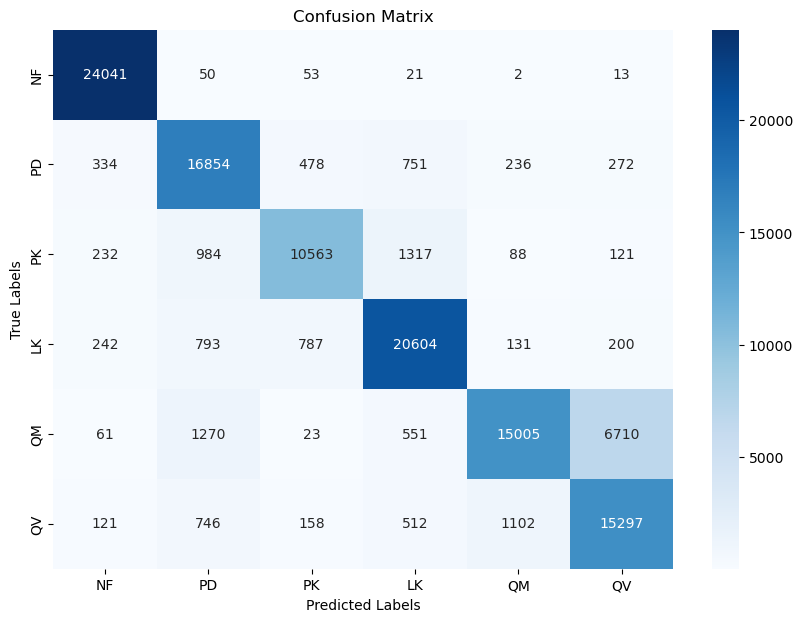

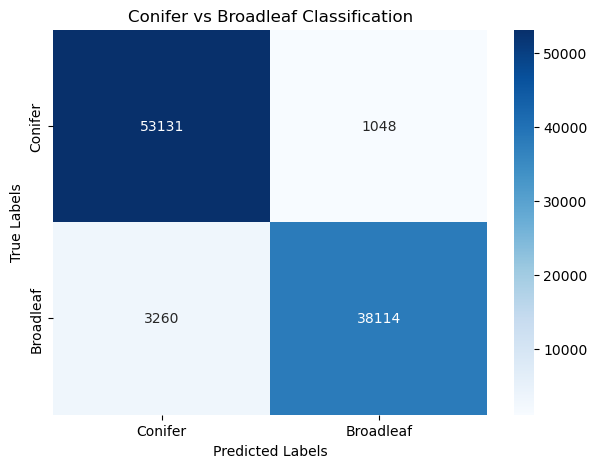

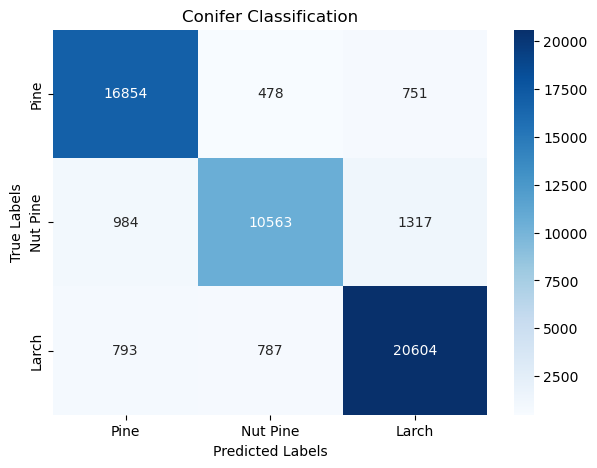

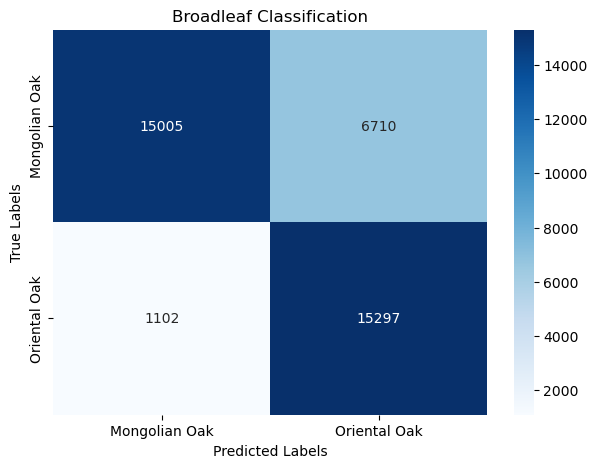


validation data


Evaluation Progress: 100%|███████████████████████████████████| 936/936 [00:10<00:00, 92.19it/s]


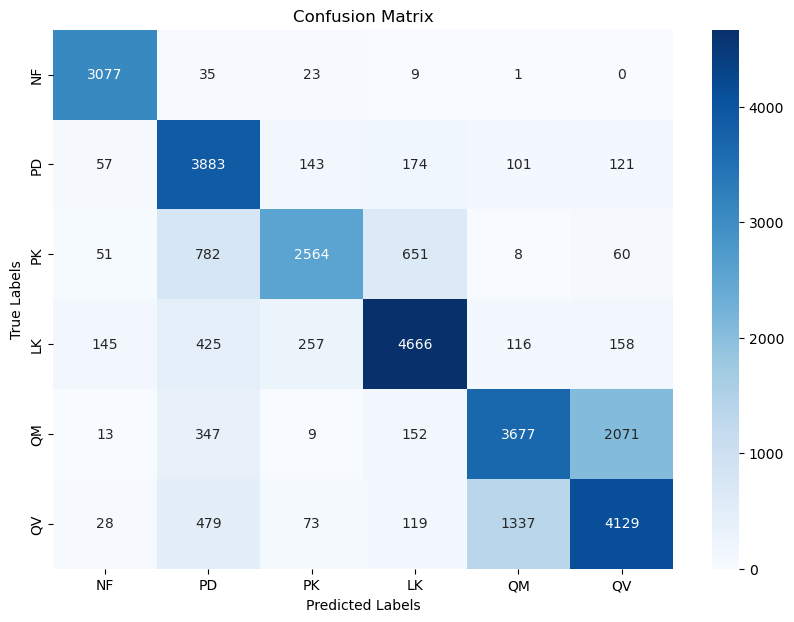

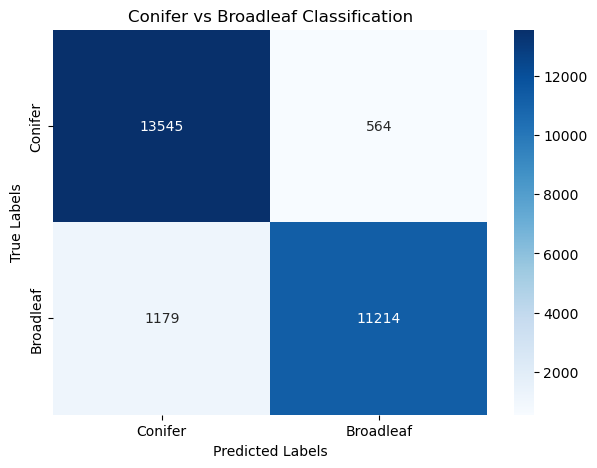

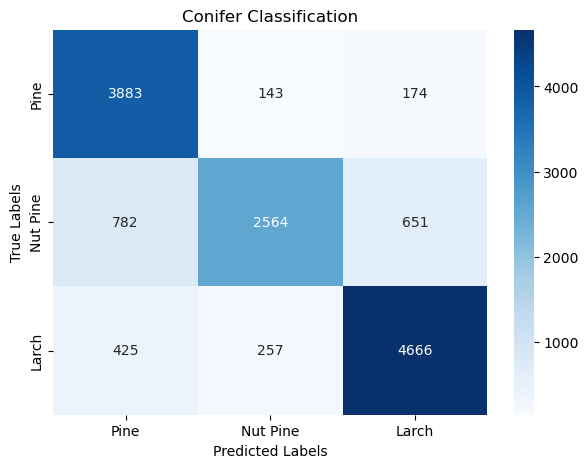

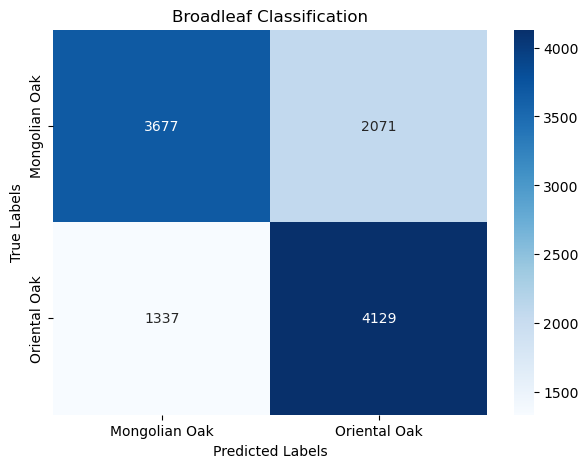

,precision,recall,f1-score,support,Category
NF,0.912786,0.978378,0.944444,3145.000000,Overall
PD,0.652495,0.866935,0.744583,4479.000000,Overall
PK,0.835451,0.622935,0.713709,4116.000000,Overall
LK,0.808525,0.809086,0.808806,5767.000000,Overall
QM,0.701718,0.586537,0.638978,6269.000000,Overall
QV,0.631442,0.669749,0.650031,6165.000000,Overall
accuracy,0.734645,0.734645,0.734645,0.734645,Overall
macro avg,0.757070,0.755603,0.750092,29941.000000,Overall
weighted avg,0.741012,0.734645,0.732122,29941.000000,Overall
Conifer,0.919927,0.960026,0.939548,14109.000000,Conifer vs Broadleaf


In [13]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [14]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

In [15]:
#input = (81,9)
transform = transforms.Compose([base_transform(bands, patch_size), transforms.Lambda(lambda x: x[:,time_idx].reshape(9,81).T)])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
model = TransformerClassifier(input_dim=9, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=81).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [17]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"transformer_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 113.51it/s]



Epoch [1/50], Train Loss: 1.0150, Train Accuracy: 58.38%, Val Loss: 0.9621, Val Accuracy: 60.47%



Epoch 2/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 112.61it/s]



Epoch [2/50], Train Loss: nan, Train Accuracy: 44.26%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 3/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 114.44it/s]



Epoch [3/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 4/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 115.72it/s]



Epoch [4/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 5/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 112.92it/s]



Epoch [5/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 6/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 114.67it/s]



Epoch [6/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 7/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 106.09it/s]



Epoch [7/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 8/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 113.37it/s]



Epoch [8/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 9/50 - Validation: 100%|██████████████████████████████| 936/936 [00:08<00:00, 113.65it/s]



Epoch [9/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 10/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 114.79it/s]



Epoch [10/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 11/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 114.08it/s]



Epoch [11/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 12/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 115.44it/s]



Epoch [12/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 13/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 115.20it/s]



Epoch [13/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 14/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 115.77it/s]



Epoch [14/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 15/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 113.63it/s]



Epoch [15/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 16/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 113.30it/s]



Epoch [16/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 17/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 113.66it/s]



Epoch [17/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 18/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 113.24it/s]



Epoch [18/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 19/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 112.70it/s]



Epoch [19/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 20/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 113.82it/s]



Epoch [20/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 21/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 113.49it/s]



Epoch [21/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 22/50 - Validation: 100%|█████████████████████████████| 936/936 [00:08<00:00, 114.10it/s]



Epoch [22/50], Train Loss: nan, Train Accuracy: 20.03%, Val Loss: nan, Val Accuracy: 10.50%



Epoch 23/50 - Training:  76%|██████████████████████▋       | 2859/3773 [00:35<00:11, 79.70it/s]


KeyboardInterrupt: 

In [18]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

## Using Bands, Time

(12,9)

In [19]:
bands = 9
patch_size = 1
checkpoints_dir = "./checkpoints/using_bands_space"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [20]:
def reshape_transform(x):
    x = x.squeeze(-1).squeeze(-1)  # (9, 12, 1, 1) → (9, 12)
    x = x.permute(1, 0)  # (9, 12) → (12, 9)
    return x

transform = transforms.Compose([
    base_transform(bands, patch_size), transforms.Lambda(reshape_transform)
])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [21]:
model = ResNet1D(in_channels=12, num_classes=6, dropout=0.2).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler 설정 (Cosine Annealing + Warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

Epoch 1/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 134.39it/s]



Epoch [1/50], Train Loss: 0.5543, Train Accuracy: 78.22%, Val Loss: 0.5697, Val Accuracy: 77.84%



Epoch 2/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 136.89it/s]



Epoch [2/50], Train Loss: 0.4116, Train Accuracy: 84.31%, Val Loss: 0.5390, Val Accuracy: 78.61%



Epoch 3/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 135.82it/s]



Epoch [3/50], Train Loss: 0.3564, Train Accuracy: 86.46%, Val Loss: 0.5500, Val Accuracy: 78.78%



Epoch 4/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 137.41it/s]



Epoch [4/50], Train Loss: 0.3227, Train Accuracy: 87.77%, Val Loss: 0.5572, Val Accuracy: 79.45%



Epoch 5/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 136.23it/s]



Epoch [5/50], Train Loss: 0.2958, Train Accuracy: 88.88%, Val Loss: 0.5630, Val Accuracy: 79.81%



Epoch 6/50 - Validation: 100%|██████████████████████████████| 940/940 [00:07<00:00, 134.03it/s]



Epoch [6/50], Train Loss: 0.2784, Train Accuracy: 89.55%, Val Loss: 0.6255, Val Accuracy: 78.61%



Epoch 7/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 134.85it/s]



Epoch [7/50], Train Loss: 0.2608, Train Accuracy: 90.16%, Val Loss: 0.5669, Val Accuracy: 81.92%



Epoch 8/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 135.65it/s]



Epoch [8/50], Train Loss: 0.2467, Train Accuracy: 90.77%, Val Loss: 0.6428, Val Accuracy: 79.55%



Epoch 9/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 135.14it/s]



Epoch [9/50], Train Loss: 0.2318, Train Accuracy: 91.41%, Val Loss: 0.5894, Val Accuracy: 80.48%



Epoch 10/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.08it/s]



Epoch [10/50], Train Loss: 0.2219, Train Accuracy: 91.70%, Val Loss: 0.6145, Val Accuracy: 79.67%



Epoch 11/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.82it/s]



Epoch [11/50], Train Loss: 0.2143, Train Accuracy: 92.02%, Val Loss: 0.5792, Val Accuracy: 81.11%



Epoch 12/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.54it/s]



Epoch [12/50], Train Loss: 0.2030, Train Accuracy: 92.44%, Val Loss: 0.6164, Val Accuracy: 79.99%



Epoch 13/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 127.82it/s]



Epoch [13/50], Train Loss: 0.1954, Train Accuracy: 92.68%, Val Loss: 0.5974, Val Accuracy: 81.46%



Epoch 14/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.71it/s]



Epoch [14/50], Train Loss: 0.1860, Train Accuracy: 93.12%, Val Loss: 0.7169, Val Accuracy: 79.61%



Epoch 15/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.27it/s]



Epoch [15/50], Train Loss: 0.1789, Train Accuracy: 93.38%, Val Loss: 0.6393, Val Accuracy: 81.05%



Epoch 16/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 129.11it/s]



Epoch [16/50], Train Loss: 0.1728, Train Accuracy: 93.63%, Val Loss: 0.6626, Val Accuracy: 80.95%



Epoch 17/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 131.25it/s]



Epoch [17/50], Train Loss: 0.1668, Train Accuracy: 93.79%, Val Loss: 0.6618, Val Accuracy: 80.92%



Epoch 18/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 131.06it/s]



Epoch [18/50], Train Loss: 0.1598, Train Accuracy: 94.12%, Val Loss: 0.7074, Val Accuracy: 79.73%



Epoch 19/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 125.07it/s]



Epoch [19/50], Train Loss: 0.1540, Train Accuracy: 94.31%, Val Loss: 0.7147, Val Accuracy: 81.82%



Epoch 20/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 127.74it/s]



Epoch [20/50], Train Loss: 0.1480, Train Accuracy: 94.48%, Val Loss: 0.7460, Val Accuracy: 80.15%



Epoch 21/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 132.72it/s]



Epoch [21/50], Train Loss: 0.1428, Train Accuracy: 94.71%, Val Loss: 0.6463, Val Accuracy: 81.47%



Epoch 22/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 130.93it/s]



Epoch [22/50], Train Loss: 0.1386, Train Accuracy: 94.88%, Val Loss: 0.6563, Val Accuracy: 82.09%



Epoch 23/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 127.15it/s]



Epoch [23/50], Train Loss: 0.1325, Train Accuracy: 95.13%, Val Loss: 0.7936, Val Accuracy: 79.69%



Epoch 24/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 129.19it/s]



Epoch [24/50], Train Loss: 0.1262, Train Accuracy: 95.31%, Val Loss: 0.7657, Val Accuracy: 80.20%



Epoch 25/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 130.80it/s]



Epoch [25/50], Train Loss: 0.1223, Train Accuracy: 95.51%, Val Loss: 0.7469, Val Accuracy: 81.25%



Epoch 26/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.99it/s]



Epoch [26/50], Train Loss: 0.1164, Train Accuracy: 95.67%, Val Loss: 0.8813, Val Accuracy: 80.72%



Epoch 27/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 132.79it/s]



Epoch [27/50], Train Loss: 0.1121, Train Accuracy: 95.86%, Val Loss: 0.7790, Val Accuracy: 81.02%



Epoch 28/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.76it/s]



Epoch [28/50], Train Loss: 0.1074, Train Accuracy: 96.04%, Val Loss: 0.8639, Val Accuracy: 80.24%



Epoch 29/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.39it/s]



Epoch [29/50], Train Loss: 0.1048, Train Accuracy: 96.08%, Val Loss: 0.8303, Val Accuracy: 80.92%



Epoch 30/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.26it/s]



Epoch [30/50], Train Loss: 0.1011, Train Accuracy: 96.34%, Val Loss: 0.7916, Val Accuracy: 81.32%



Epoch 31/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.21it/s]



Epoch [31/50], Train Loss: 0.0960, Train Accuracy: 96.44%, Val Loss: 0.7931, Val Accuracy: 81.43%



Epoch 32/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 125.20it/s]



Epoch [32/50], Train Loss: 0.0936, Train Accuracy: 96.54%, Val Loss: 0.8801, Val Accuracy: 80.44%



Epoch 33/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.46it/s]



Epoch [33/50], Train Loss: 0.0884, Train Accuracy: 96.79%, Val Loss: 0.8773, Val Accuracy: 80.75%



Epoch 34/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.01it/s]



Epoch [34/50], Train Loss: 0.0861, Train Accuracy: 96.80%, Val Loss: 0.8680, Val Accuracy: 80.74%



Epoch 35/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 131.80it/s]



Epoch [35/50], Train Loss: 0.0836, Train Accuracy: 96.89%, Val Loss: 0.8692, Val Accuracy: 81.52%



Epoch 36/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 132.26it/s]



Epoch [36/50], Train Loss: 0.0792, Train Accuracy: 97.09%, Val Loss: 0.9926, Val Accuracy: 79.96%



Epoch 37/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 132.82it/s]



Epoch [37/50], Train Loss: 0.0774, Train Accuracy: 97.15%, Val Loss: 0.9181, Val Accuracy: 80.41%



Epoch 38/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.66it/s]



Epoch [38/50], Train Loss: 0.0751, Train Accuracy: 97.20%, Val Loss: 0.9226, Val Accuracy: 80.70%



Epoch 39/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.52it/s]



Epoch [39/50], Train Loss: 0.0723, Train Accuracy: 97.33%, Val Loss: 0.8827, Val Accuracy: 81.07%



Epoch 40/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 134.09it/s]



Epoch [40/50], Train Loss: 0.0690, Train Accuracy: 97.47%, Val Loss: 0.9300, Val Accuracy: 80.65%



Epoch 41/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.10it/s]



Epoch [41/50], Train Loss: 0.0676, Train Accuracy: 97.52%, Val Loss: 0.9525, Val Accuracy: 80.65%



Epoch 42/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 132.95it/s]



Epoch [42/50], Train Loss: 0.0666, Train Accuracy: 97.50%, Val Loss: 0.9869, Val Accuracy: 80.56%



Epoch 43/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.82it/s]



Epoch [43/50], Train Loss: 0.0658, Train Accuracy: 97.59%, Val Loss: 0.9410, Val Accuracy: 80.59%



Epoch 44/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.36it/s]



Epoch [44/50], Train Loss: 0.0631, Train Accuracy: 97.63%, Val Loss: 0.9504, Val Accuracy: 81.05%



Epoch 45/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.64it/s]



Epoch [45/50], Train Loss: 0.0629, Train Accuracy: 97.64%, Val Loss: 0.9811, Val Accuracy: 80.54%



Epoch 46/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.10it/s]



Epoch [46/50], Train Loss: 0.0604, Train Accuracy: 97.77%, Val Loss: 0.9754, Val Accuracy: 80.97%



Epoch 47/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.63it/s]



Epoch [47/50], Train Loss: 0.0598, Train Accuracy: 97.74%, Val Loss: 0.9794, Val Accuracy: 80.91%



Epoch 48/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.59it/s]



Epoch [48/50], Train Loss: 0.0593, Train Accuracy: 97.81%, Val Loss: 0.9734, Val Accuracy: 80.97%



Epoch 49/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.49it/s]



Epoch [49/50], Train Loss: 0.0591, Train Accuracy: 97.85%, Val Loss: 0.9719, Val Accuracy: 81.00%



Epoch 50/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.09it/s]



Epoch [50/50], Train Loss: 0.0586, Train Accuracy: 97.81%, Val Loss: 0.9557, Val Accuracy: 81.04%


train data


Evaluation Progress: 100%|████████████████████████████████| 3796/3796 [00:30<00:00, 123.25it/s]


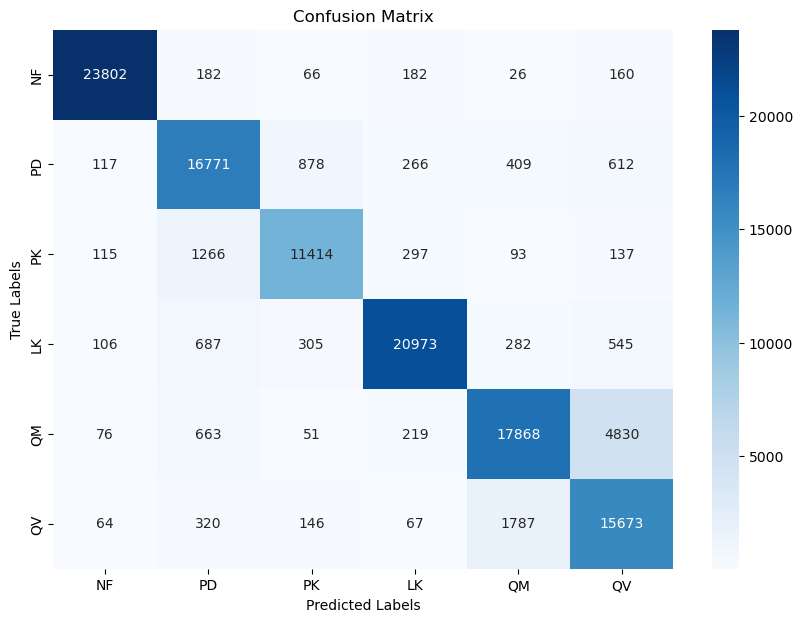

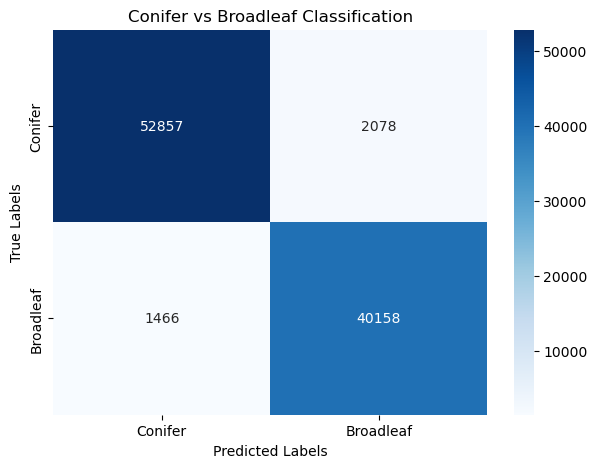

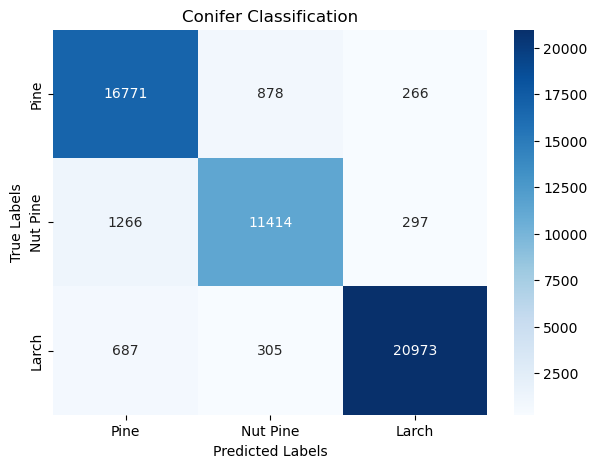

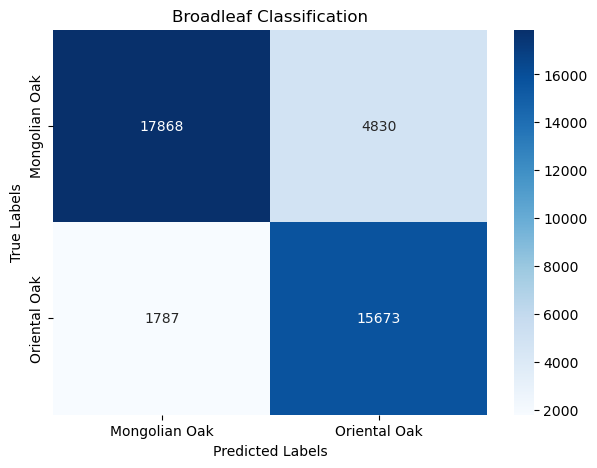


validation data


Evaluation Progress: 100%|██████████████████████████████████| 940/940 [00:07<00:00, 123.59it/s]


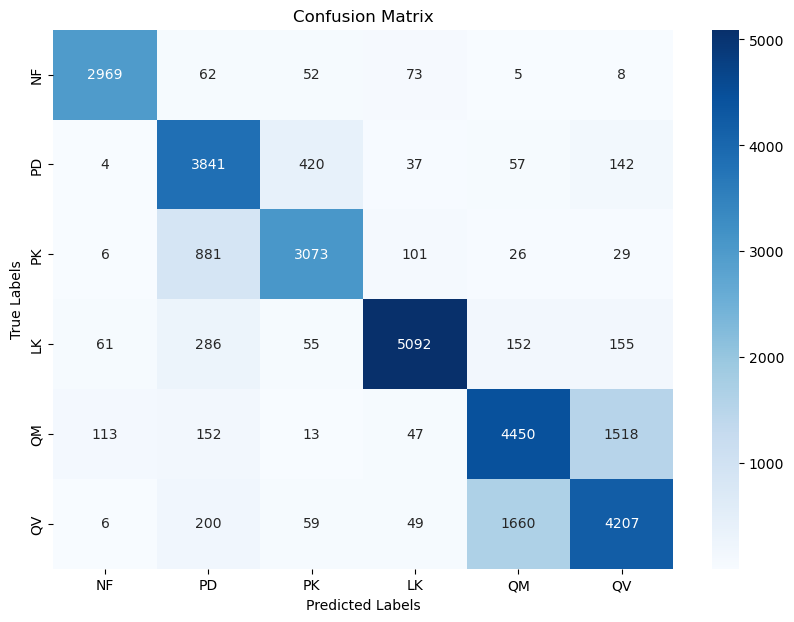

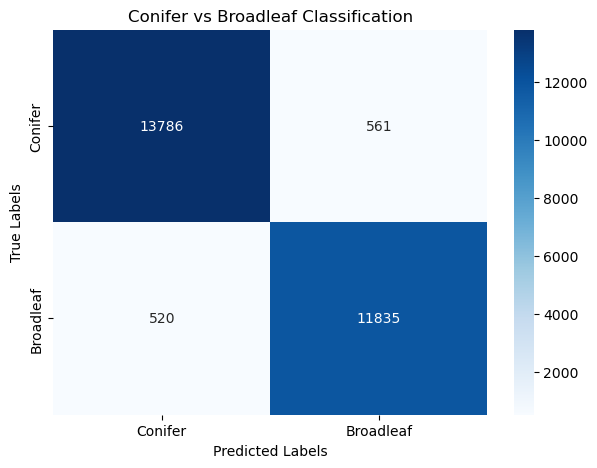

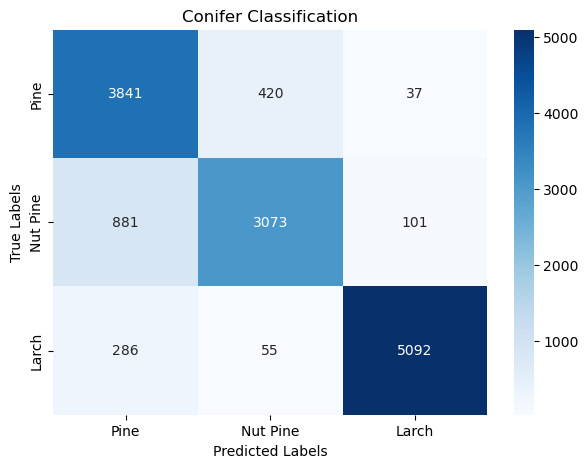

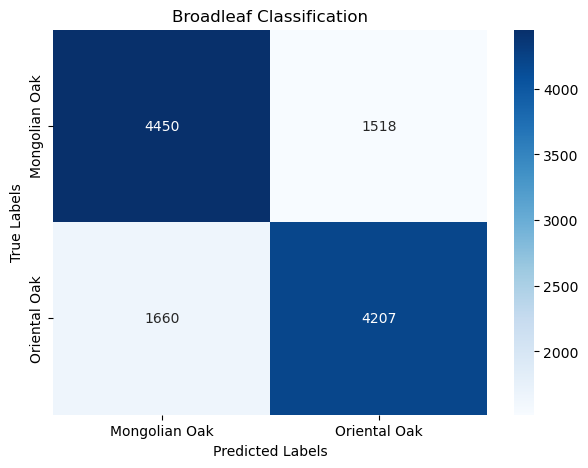

,precision,recall,f1-score,support,Category
NF,0.939854,0.936889,0.938369,3169.000000,Overall
PD,0.708410,0.853366,0.774161,4501.000000,Overall
PK,0.836874,0.746599,0.789163,4116.000000,Overall
LK,0.943138,0.877780,0.909286,5801.000000,Overall
QM,0.700787,0.707135,0.703947,6293.000000,Overall
QV,0.694339,0.680634,0.687418,6181.000000,Overall
accuracy,0.786135,0.786135,0.786135,0.786135,Overall
macro avg,0.803900,0.800400,0.800391,30061.000000,Overall
weighted avg,0.791206,0.786135,0.787067,30061.000000,Overall
Conifer,0.963652,0.960898,0.962273,14347.000000,Conifer vs Broadleaf


In [22]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet1d_b_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [23]:
model =  TransformerClassifier(input_dim=9, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler 설정 (Cosine Annealing + Warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

Epoch 1/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 167.87it/s]



Epoch [1/50], Train Loss: 0.7793, Train Accuracy: 69.70%, Val Loss: 0.6451, Val Accuracy: 72.96%



Epoch 2/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 164.96it/s]



Epoch [2/50], Train Loss: 0.5697, Train Accuracy: 77.79%, Val Loss: 0.5587, Val Accuracy: 78.04%



Epoch 3/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 166.90it/s]



Epoch [3/50], Train Loss: 0.5094, Train Accuracy: 80.23%, Val Loss: 0.5411, Val Accuracy: 78.82%



Epoch 4/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 167.09it/s]



Epoch [4/50], Train Loss: 0.4728, Train Accuracy: 81.66%, Val Loss: 0.5183, Val Accuracy: 79.53%



Epoch 5/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 166.24it/s]



Epoch [5/50], Train Loss: 0.4457, Train Accuracy: 82.74%, Val Loss: 0.5416, Val Accuracy: 79.72%



Epoch 6/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 163.19it/s]



Epoch [6/50], Train Loss: 0.4242, Train Accuracy: 83.79%, Val Loss: 0.4943, Val Accuracy: 81.22%



Epoch 7/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 168.50it/s]



Epoch [7/50], Train Loss: 0.4088, Train Accuracy: 84.39%, Val Loss: 0.5199, Val Accuracy: 79.82%



Epoch 8/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 169.08it/s]



Epoch [8/50], Train Loss: 0.3966, Train Accuracy: 84.81%, Val Loss: 0.5638, Val Accuracy: 77.88%



Epoch 9/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 164.91it/s]



Epoch [9/50], Train Loss: 0.3867, Train Accuracy: 85.29%, Val Loss: 0.5152, Val Accuracy: 80.71%



Epoch 10/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.21it/s]



Epoch [10/50], Train Loss: 0.3735, Train Accuracy: 85.74%, Val Loss: 0.4862, Val Accuracy: 81.15%



Epoch 11/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.03it/s]



Epoch [11/50], Train Loss: 0.3591, Train Accuracy: 86.42%, Val Loss: 0.4642, Val Accuracy: 83.04%



Epoch 12/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.65it/s]



Epoch [12/50], Train Loss: 0.3499, Train Accuracy: 86.73%, Val Loss: 0.4716, Val Accuracy: 82.37%



Epoch 13/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.60it/s]



Epoch [13/50], Train Loss: 0.3417, Train Accuracy: 87.14%, Val Loss: 0.6344, Val Accuracy: 76.87%



Epoch 14/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.23it/s]



Epoch [14/50], Train Loss: 0.3349, Train Accuracy: 87.32%, Val Loss: 0.5469, Val Accuracy: 80.14%



Epoch 15/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.35it/s]



Epoch [15/50], Train Loss: 0.3303, Train Accuracy: 87.46%, Val Loss: 0.5090, Val Accuracy: 81.14%



Epoch 16/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.43it/s]



Epoch [16/50], Train Loss: 0.3213, Train Accuracy: 87.88%, Val Loss: 0.5433, Val Accuracy: 80.59%



Epoch 17/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.81it/s]



Epoch [17/50], Train Loss: 0.3179, Train Accuracy: 87.93%, Val Loss: 0.5172, Val Accuracy: 81.27%



Epoch 18/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 165.42it/s]



Epoch [18/50], Train Loss: 0.3107, Train Accuracy: 88.33%, Val Loss: 0.5407, Val Accuracy: 81.29%



Epoch 19/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.00it/s]



Epoch [19/50], Train Loss: 0.3024, Train Accuracy: 88.61%, Val Loss: 0.4945, Val Accuracy: 82.47%



Epoch 20/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.73it/s]



Epoch [20/50], Train Loss: 0.2970, Train Accuracy: 88.87%, Val Loss: 0.4871, Val Accuracy: 82.67%



Epoch 21/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.83it/s]



Epoch [21/50], Train Loss: 0.2928, Train Accuracy: 88.95%, Val Loss: 0.4887, Val Accuracy: 81.89%



Epoch 22/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.19it/s]



Epoch [22/50], Train Loss: 0.2874, Train Accuracy: 89.18%, Val Loss: 0.4748, Val Accuracy: 82.94%



Epoch 23/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.20it/s]



Epoch [23/50], Train Loss: 0.2871, Train Accuracy: 89.21%, Val Loss: 0.5088, Val Accuracy: 81.46%



Epoch 24/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.65it/s]



Epoch [24/50], Train Loss: 0.2809, Train Accuracy: 89.37%, Val Loss: 0.4983, Val Accuracy: 82.26%



Epoch 25/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.37it/s]



Epoch [25/50], Train Loss: 0.2773, Train Accuracy: 89.55%, Val Loss: 0.5150, Val Accuracy: 82.15%



Epoch 26/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.01it/s]



Epoch [26/50], Train Loss: 0.2714, Train Accuracy: 89.79%, Val Loss: 0.5222, Val Accuracy: 81.61%



Epoch 27/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 171.70it/s]



Epoch [27/50], Train Loss: 0.2689, Train Accuracy: 89.90%, Val Loss: 0.5038, Val Accuracy: 82.52%



Epoch 28/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.48it/s]



Epoch [28/50], Train Loss: 0.2639, Train Accuracy: 90.12%, Val Loss: 0.5563, Val Accuracy: 81.18%



Epoch 29/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.54it/s]



Epoch [29/50], Train Loss: 0.2582, Train Accuracy: 90.39%, Val Loss: 0.4924, Val Accuracy: 82.92%



Epoch 30/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.02it/s]



Epoch [30/50], Train Loss: 0.2563, Train Accuracy: 90.38%, Val Loss: 0.5063, Val Accuracy: 82.47%



Epoch 31/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.42it/s]



Epoch [31/50], Train Loss: 0.2505, Train Accuracy: 90.68%, Val Loss: 0.5192, Val Accuracy: 82.21%



Epoch 32/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.14it/s]



Epoch [32/50], Train Loss: 0.2496, Train Accuracy: 90.81%, Val Loss: 0.5301, Val Accuracy: 81.79%



Epoch 33/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.76it/s]



Epoch [33/50], Train Loss: 0.2439, Train Accuracy: 90.88%, Val Loss: 0.5112, Val Accuracy: 82.63%



Epoch 34/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.18it/s]



Epoch [34/50], Train Loss: 0.2419, Train Accuracy: 91.03%, Val Loss: 0.5162, Val Accuracy: 82.86%



Epoch 35/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.38it/s]



Epoch [35/50], Train Loss: 0.2369, Train Accuracy: 91.21%, Val Loss: 0.5295, Val Accuracy: 82.01%



Epoch 36/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.33it/s]



Epoch [36/50], Train Loss: 0.2356, Train Accuracy: 91.23%, Val Loss: 0.5630, Val Accuracy: 81.33%



Epoch 37/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.91it/s]



Epoch [37/50], Train Loss: 0.2347, Train Accuracy: 91.28%, Val Loss: 0.4975, Val Accuracy: 82.95%



Epoch 38/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.66it/s]



Epoch [38/50], Train Loss: 0.2318, Train Accuracy: 91.43%, Val Loss: 0.5445, Val Accuracy: 81.99%



Epoch 39/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.87it/s]



Epoch [39/50], Train Loss: 0.2291, Train Accuracy: 91.47%, Val Loss: 0.5471, Val Accuracy: 81.85%



Epoch 40/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.90it/s]



Epoch [40/50], Train Loss: 0.2263, Train Accuracy: 91.69%, Val Loss: 0.5145, Val Accuracy: 83.04%



Epoch 41/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.91it/s]



Epoch [41/50], Train Loss: 0.2249, Train Accuracy: 91.62%, Val Loss: 0.5153, Val Accuracy: 82.75%



Epoch 42/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.96it/s]



Epoch [42/50], Train Loss: 0.2217, Train Accuracy: 91.84%, Val Loss: 0.5232, Val Accuracy: 82.75%



Epoch 43/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.53it/s]



Epoch [43/50], Train Loss: 0.2226, Train Accuracy: 91.76%, Val Loss: 0.5472, Val Accuracy: 82.15%



Epoch 44/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 166.76it/s]



Epoch [44/50], Train Loss: 0.2198, Train Accuracy: 91.82%, Val Loss: 0.5305, Val Accuracy: 82.69%



Epoch 45/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.79it/s]



Epoch [45/50], Train Loss: 0.2186, Train Accuracy: 91.88%, Val Loss: 0.5440, Val Accuracy: 82.06%



Epoch 46/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.25it/s]



Epoch [46/50], Train Loss: 0.2176, Train Accuracy: 91.91%, Val Loss: 0.5291, Val Accuracy: 82.45%



Epoch 47/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.03it/s]



Epoch [47/50], Train Loss: 0.2166, Train Accuracy: 92.08%, Val Loss: 0.5292, Val Accuracy: 82.47%



Epoch 48/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.67it/s]



Epoch [48/50], Train Loss: 0.2167, Train Accuracy: 91.97%, Val Loss: 0.5378, Val Accuracy: 82.30%



Epoch 49/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.81it/s]



Epoch [49/50], Train Loss: 0.2151, Train Accuracy: 92.02%, Val Loss: 0.5316, Val Accuracy: 82.46%



Epoch 50/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.27it/s]



Epoch [50/50], Train Loss: 0.2159, Train Accuracy: 92.02%, Val Loss: 0.5338, Val Accuracy: 82.46%


train data


Evaluation Progress: 100%|████████████████████████████████| 3796/3796 [00:22<00:00, 168.21it/s]


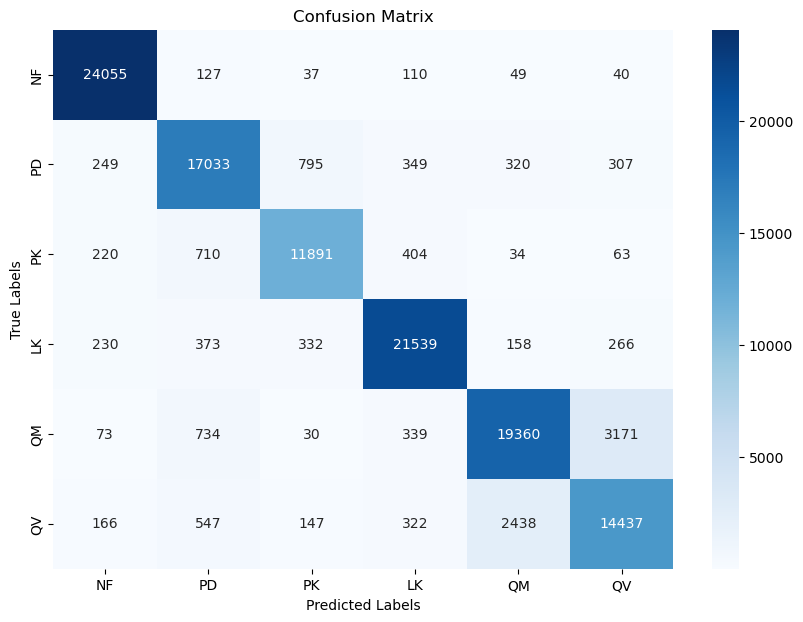

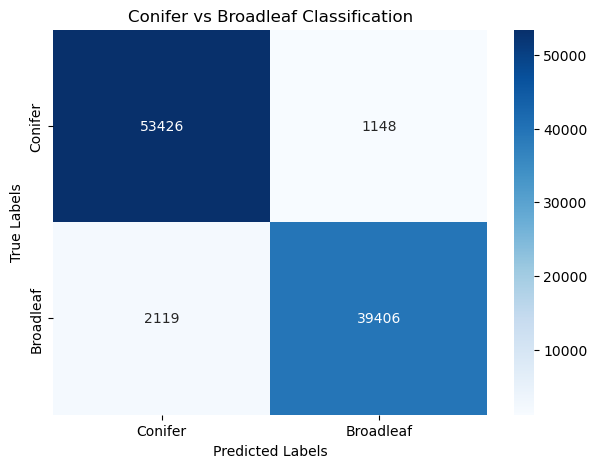

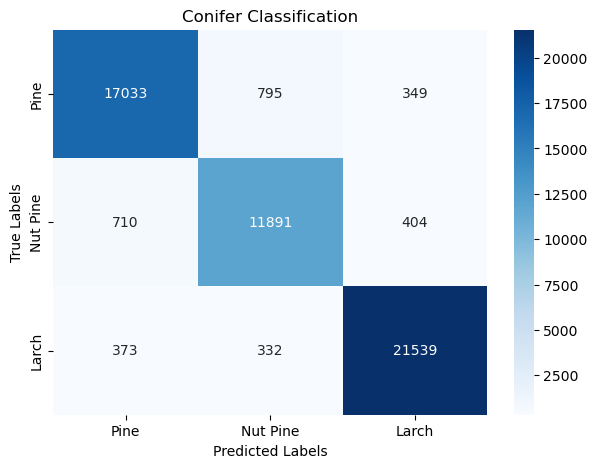

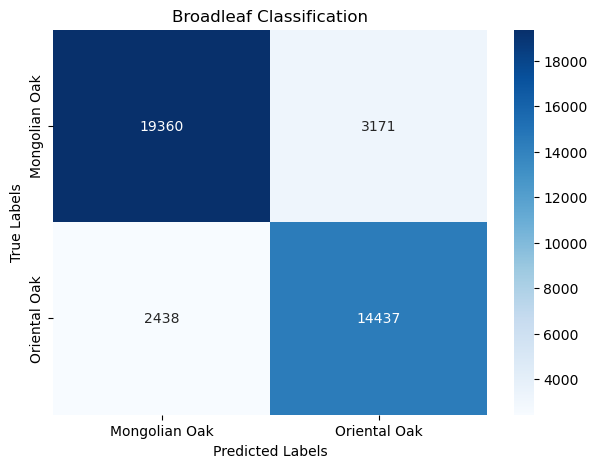


validation data


Evaluation Progress: 100%|██████████████████████████████████| 940/940 [00:05<00:00, 171.62it/s]


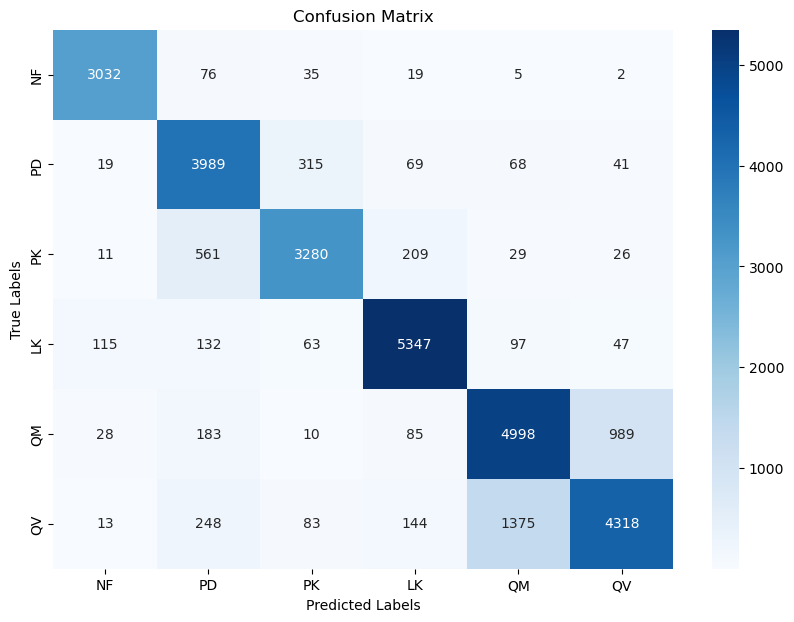

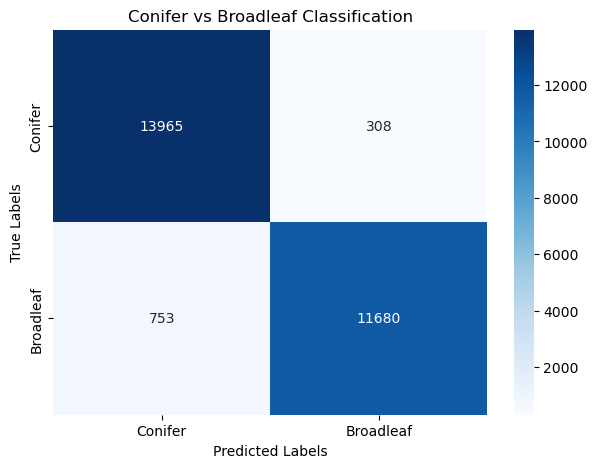

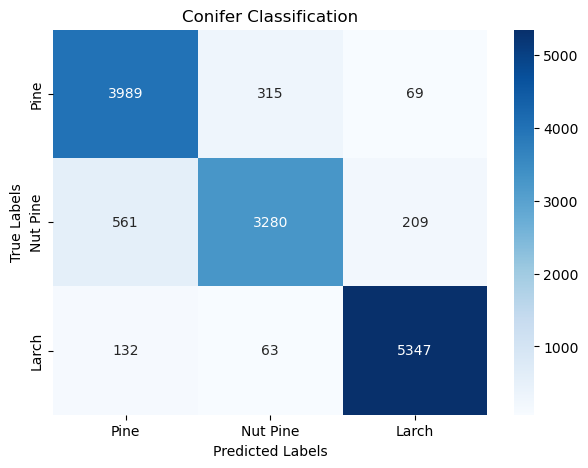

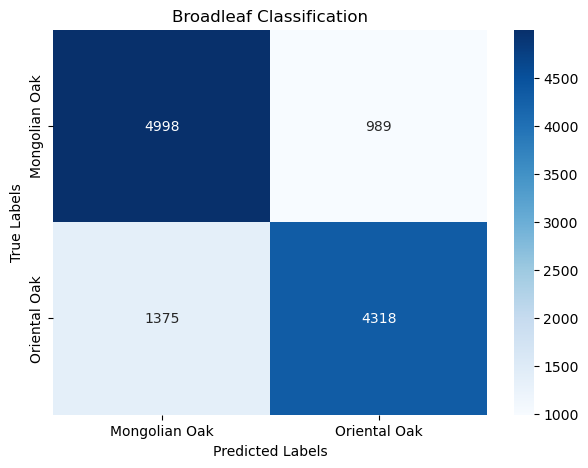

,precision,recall,f1-score,support,Category
NF,0.942200,0.956769,0.949429,3169.000000,Overall
PD,0.768742,0.886248,0.823323,4501.000000,Overall
PK,0.866350,0.796890,0.830170,4116.000000,Overall
LK,0.910438,0.921738,0.916053,5801.000000,Overall
QM,0.760499,0.794216,0.776992,6293.000000,Overall
QV,0.796238,0.698592,0.744226,6181.000000,Overall
accuracy,0.830445,0.830445,0.830445,0.830445,Overall
macro avg,0.840744,0.842409,0.840032,30061.000000,Overall
weighted avg,0.831664,0.830445,0.829486,30061.000000,Overall
Conifer,0.948838,0.978421,0.963402,14273.000000,Conifer vs Broadleaf


In [24]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"transformer_b_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [25]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

input.shape = (9,12) -> Time 분석 transformer는 time이 토큰인게 좋았다.

In [26]:
bands = 9
patch_size = 1
checkpoints_dir = "./checkpoints/using_bands_space"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [27]:
def reshape_transform(x):
    x = x.squeeze(-1).squeeze(-1)  # (9, 12, 1, 1) → (9, 12)
    return x

transform = transforms.Compose([
    base_transform(bands, patch_size), transforms.Lambda(reshape_transform)
])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [28]:
model = ResNet1D(in_channels=9, num_classes=6, dropout=0.2).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler 설정 (Cosine Annealing + Warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

Epoch 1/50 - Validation: 100%|██████████████████████████████| 940/940 [00:07<00:00, 133.53it/s]



Epoch [1/50], Train Loss: 0.5429, Train Accuracy: 78.69%, Val Loss: 0.5364, Val Accuracy: 79.21%



Epoch 2/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 135.10it/s]



Epoch [2/50], Train Loss: 0.3977, Train Accuracy: 84.74%, Val Loss: 0.4652, Val Accuracy: 81.53%



Epoch 3/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 135.12it/s]



Epoch [3/50], Train Loss: 0.3477, Train Accuracy: 86.82%, Val Loss: 0.5298, Val Accuracy: 80.39%



Epoch 4/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 137.83it/s]



Epoch [4/50], Train Loss: 0.3116, Train Accuracy: 88.24%, Val Loss: 0.5222, Val Accuracy: 81.47%



Epoch 5/50 - Validation: 100%|██████████████████████████████| 940/940 [00:07<00:00, 133.93it/s]



Epoch [5/50], Train Loss: 0.2878, Train Accuracy: 89.19%, Val Loss: 0.4855, Val Accuracy: 82.32%



Epoch 6/50 - Validation: 100%|██████████████████████████████| 940/940 [00:07<00:00, 133.66it/s]



Epoch [6/50], Train Loss: 0.2682, Train Accuracy: 89.99%, Val Loss: 0.5445, Val Accuracy: 81.25%



Epoch 7/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 138.03it/s]



Epoch [7/50], Train Loss: 0.2508, Train Accuracy: 90.80%, Val Loss: 0.5272, Val Accuracy: 81.80%



Epoch 8/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 137.18it/s]



Epoch [8/50], Train Loss: 0.2360, Train Accuracy: 91.27%, Val Loss: 0.5554, Val Accuracy: 80.84%



Epoch 9/50 - Validation: 100%|██████████████████████████████| 940/940 [00:06<00:00, 136.59it/s]



Epoch [9/50], Train Loss: 0.2238, Train Accuracy: 91.80%, Val Loss: 0.5488, Val Accuracy: 82.40%



Epoch 10/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.38it/s]



Epoch [10/50], Train Loss: 0.2109, Train Accuracy: 92.25%, Val Loss: 0.5866, Val Accuracy: 82.44%



Epoch 11/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.10it/s]



Epoch [11/50], Train Loss: 0.2022, Train Accuracy: 92.63%, Val Loss: 0.6011, Val Accuracy: 82.08%



Epoch 12/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.70it/s]



Epoch [12/50], Train Loss: 0.1937, Train Accuracy: 92.84%, Val Loss: 0.5449, Val Accuracy: 82.57%



Epoch 13/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.90it/s]



Epoch [13/50], Train Loss: 0.1832, Train Accuracy: 93.25%, Val Loss: 0.6953, Val Accuracy: 80.66%



Epoch 14/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 131.67it/s]



Epoch [14/50], Train Loss: 0.1757, Train Accuracy: 93.66%, Val Loss: 0.6111, Val Accuracy: 82.71%



Epoch 15/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.30it/s]



Epoch [15/50], Train Loss: 0.1683, Train Accuracy: 93.87%, Val Loss: 0.6557, Val Accuracy: 82.91%



Epoch 16/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.40it/s]



Epoch [16/50], Train Loss: 0.1611, Train Accuracy: 94.13%, Val Loss: 0.6375, Val Accuracy: 82.86%



Epoch 17/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.49it/s]



Epoch [17/50], Train Loss: 0.1541, Train Accuracy: 94.34%, Val Loss: 0.6119, Val Accuracy: 82.56%



Epoch 18/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.53it/s]



Epoch [18/50], Train Loss: 0.1472, Train Accuracy: 94.64%, Val Loss: 0.6932, Val Accuracy: 82.29%



Epoch 19/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 134.10it/s]



Epoch [19/50], Train Loss: 0.1428, Train Accuracy: 94.80%, Val Loss: 0.6431, Val Accuracy: 82.65%



Epoch 20/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.00it/s]



Epoch [20/50], Train Loss: 0.1362, Train Accuracy: 95.04%, Val Loss: 0.7100, Val Accuracy: 82.43%



Epoch 21/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.08it/s]



Epoch [21/50], Train Loss: 0.1318, Train Accuracy: 95.18%, Val Loss: 0.6750, Val Accuracy: 82.78%



Epoch 22/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.48it/s]



Epoch [22/50], Train Loss: 0.1261, Train Accuracy: 95.42%, Val Loss: 0.7388, Val Accuracy: 82.01%



Epoch 23/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.39it/s]



Epoch [23/50], Train Loss: 0.1206, Train Accuracy: 95.61%, Val Loss: 0.7772, Val Accuracy: 81.36%



Epoch 24/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.83it/s]



Epoch [24/50], Train Loss: 0.1173, Train Accuracy: 95.71%, Val Loss: 0.7931, Val Accuracy: 81.71%



Epoch 25/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.12it/s]



Epoch [25/50], Train Loss: 0.1128, Train Accuracy: 95.89%, Val Loss: 0.7001, Val Accuracy: 83.23%



Epoch 26/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.79it/s]



Epoch [26/50], Train Loss: 0.1074, Train Accuracy: 96.08%, Val Loss: 0.7033, Val Accuracy: 83.04%



Epoch 27/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.64it/s]



Epoch [27/50], Train Loss: 0.1020, Train Accuracy: 96.22%, Val Loss: 0.8121, Val Accuracy: 81.46%



Epoch 28/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.59it/s]



Epoch [28/50], Train Loss: 0.0971, Train Accuracy: 96.41%, Val Loss: 0.7697, Val Accuracy: 82.74%



Epoch 29/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.43it/s]



Epoch [29/50], Train Loss: 0.0940, Train Accuracy: 96.54%, Val Loss: 0.7647, Val Accuracy: 82.60%



Epoch 30/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.69it/s]



Epoch [30/50], Train Loss: 0.0917, Train Accuracy: 96.66%, Val Loss: 0.7678, Val Accuracy: 83.45%



Epoch 31/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.87it/s]



Epoch [31/50], Train Loss: 0.0893, Train Accuracy: 96.72%, Val Loss: 0.7645, Val Accuracy: 82.58%



Epoch 32/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.60it/s]



Epoch [32/50], Train Loss: 0.0849, Train Accuracy: 96.89%, Val Loss: 0.7899, Val Accuracy: 82.86%



Epoch 33/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 138.56it/s]



Epoch [33/50], Train Loss: 0.0803, Train Accuracy: 97.06%, Val Loss: 0.8271, Val Accuracy: 82.52%



Epoch 34/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.40it/s]



Epoch [34/50], Train Loss: 0.0789, Train Accuracy: 97.08%, Val Loss: 0.8216, Val Accuracy: 82.87%



Epoch 35/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.64it/s]



Epoch [35/50], Train Loss: 0.0756, Train Accuracy: 97.18%, Val Loss: 0.8779, Val Accuracy: 82.30%



Epoch 36/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.66it/s]



Epoch [36/50], Train Loss: 0.0732, Train Accuracy: 97.33%, Val Loss: 0.8553, Val Accuracy: 82.20%



Epoch 37/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 138.22it/s]



Epoch [37/50], Train Loss: 0.0712, Train Accuracy: 97.38%, Val Loss: 0.8312, Val Accuracy: 82.70%



Epoch 38/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.47it/s]



Epoch [38/50], Train Loss: 0.0677, Train Accuracy: 97.54%, Val Loss: 0.9550, Val Accuracy: 81.54%



Epoch 39/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 139.27it/s]



Epoch [39/50], Train Loss: 0.0649, Train Accuracy: 97.63%, Val Loss: 0.9295, Val Accuracy: 82.43%



Epoch 40/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 136.77it/s]



Epoch [40/50], Train Loss: 0.0625, Train Accuracy: 97.72%, Val Loss: 0.8622, Val Accuracy: 82.56%



Epoch 41/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 139.03it/s]



Epoch [41/50], Train Loss: 0.0614, Train Accuracy: 97.73%, Val Loss: 0.8962, Val Accuracy: 82.46%



Epoch 42/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.77it/s]



Epoch [42/50], Train Loss: 0.0602, Train Accuracy: 97.80%, Val Loss: 0.8964, Val Accuracy: 82.67%



Epoch 43/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.72it/s]



Epoch [43/50], Train Loss: 0.0580, Train Accuracy: 97.89%, Val Loss: 0.8938, Val Accuracy: 82.95%



Epoch 44/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.22it/s]



Epoch [44/50], Train Loss: 0.0588, Train Accuracy: 97.87%, Val Loss: 0.9151, Val Accuracy: 82.50%



Epoch 45/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.67it/s]



Epoch [45/50], Train Loss: 0.0553, Train Accuracy: 97.96%, Val Loss: 0.9022, Val Accuracy: 82.71%



Epoch 46/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.06it/s]



Epoch [46/50], Train Loss: 0.0561, Train Accuracy: 97.93%, Val Loss: 0.9572, Val Accuracy: 82.30%



Epoch 47/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 134.78it/s]



Epoch [47/50], Train Loss: 0.0560, Train Accuracy: 97.96%, Val Loss: 0.9158, Val Accuracy: 82.56%



Epoch 48/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 137.17it/s]



Epoch [48/50], Train Loss: 0.0549, Train Accuracy: 98.03%, Val Loss: 0.9382, Val Accuracy: 82.33%



Epoch 49/50 - Validation: 100%|█████████████████████████████| 940/940 [00:06<00:00, 135.63it/s]



Epoch [49/50], Train Loss: 0.0535, Train Accuracy: 98.07%, Val Loss: 0.9033, Val Accuracy: 82.86%



Epoch 50/50 - Validation: 100%|█████████████████████████████| 940/940 [00:07<00:00, 133.32it/s]



Epoch [50/50], Train Loss: 0.0530, Train Accuracy: 98.06%, Val Loss: 0.9251, Val Accuracy: 82.38%


train data


Evaluation Progress: 100%|████████████████████████████████| 3796/3796 [00:30<00:00, 124.97it/s]


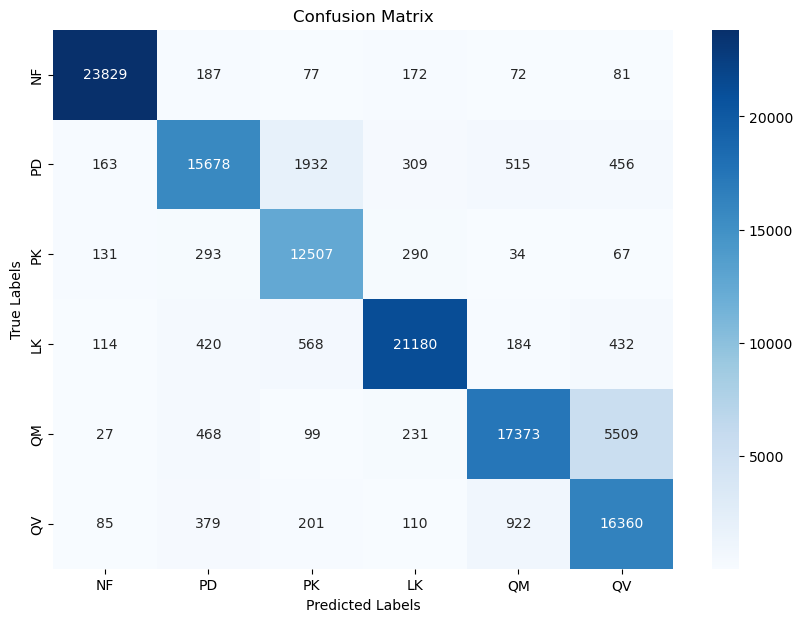

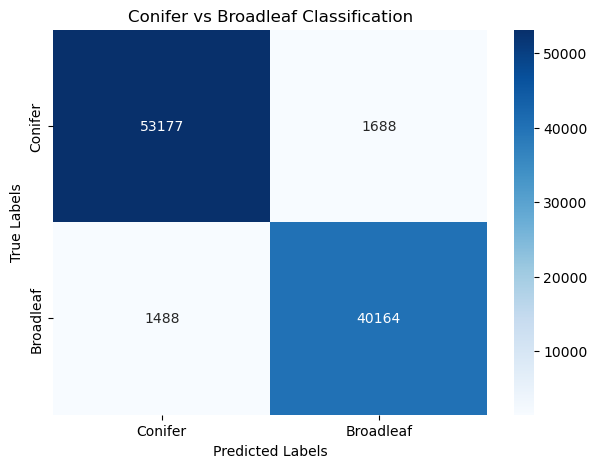

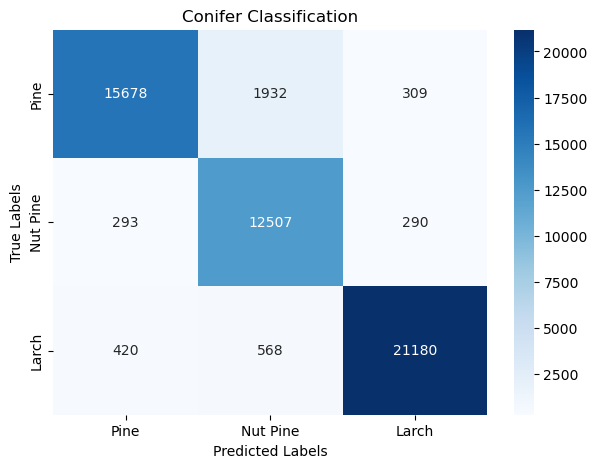

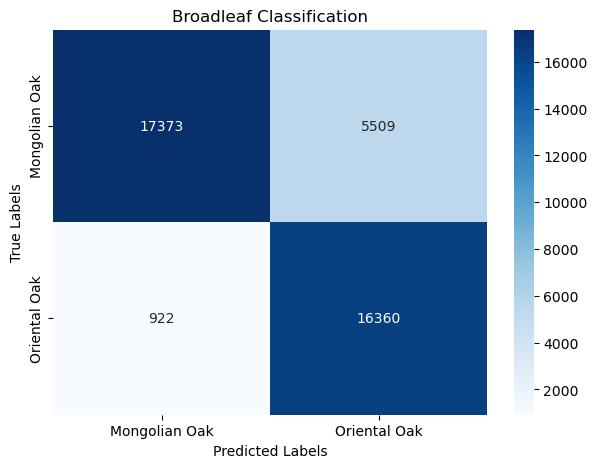


validation data


Evaluation Progress: 100%|██████████████████████████████████| 940/940 [00:07<00:00, 126.25it/s]


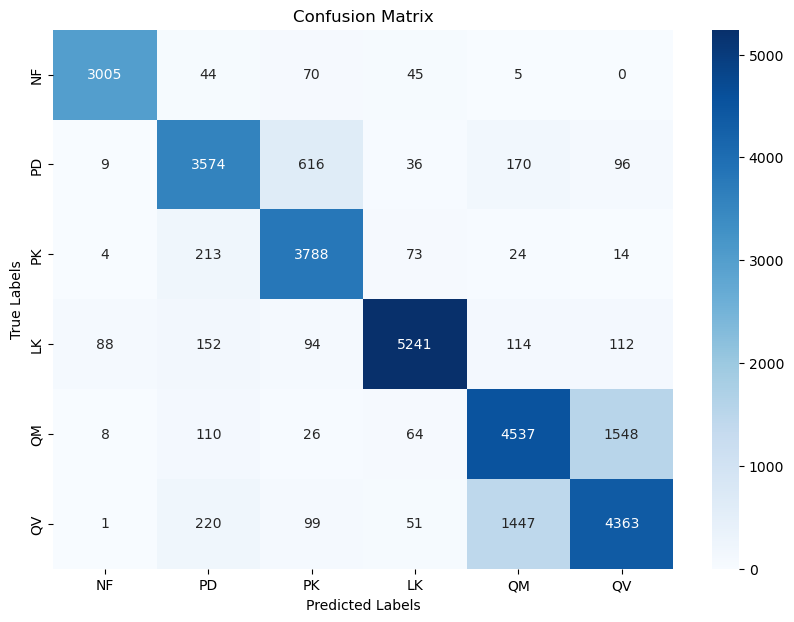

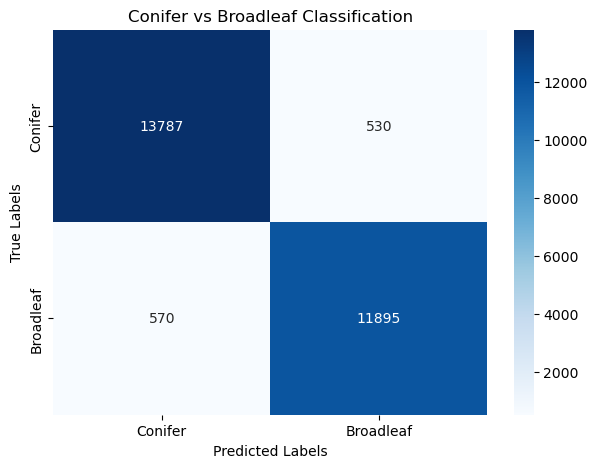

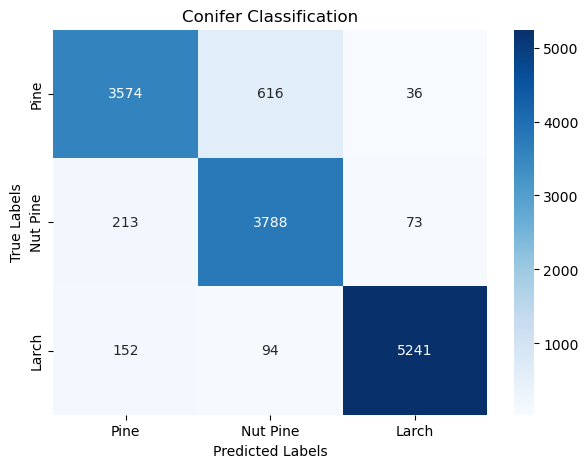

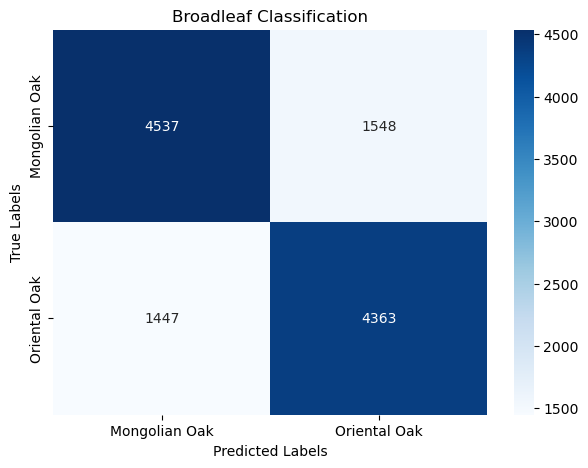

,precision,recall,f1-score,support,Category
NF,0.964687,0.948249,0.956397,3169.000000,Overall
PD,0.828658,0.794046,0.810983,4501.000000,Overall
PK,0.807160,0.920311,0.860030,4116.000000,Overall
LK,0.951180,0.903465,0.926709,5801.000000,Overall
QM,0.720502,0.720960,0.720731,6293.000000,Overall
QV,0.711397,0.705873,0.708624,6181.000000,Overall
accuracy,0.815276,0.815276,0.815276,0.815276,Overall
macro avg,0.830597,0.832150,0.830579,30061.000000,Overall
weighted avg,0.816946,0.815276,0.815420,30061.000000,Overall
Conifer,0.960298,0.962981,0.961638,14317.000000,Conifer vs Broadleaf


In [29]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet1d_t_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [30]:
model =  TransformerClassifier(input_dim=12, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=9).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler 설정 (Cosine Annealing + Warmup)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

Epoch 1/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 169.95it/s]



Epoch [1/50], Train Loss: 0.8560, Train Accuracy: 65.85%, Val Loss: 0.6888, Val Accuracy: 69.65%



Epoch 2/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 168.35it/s]



Epoch [2/50], Train Loss: 0.6297, Train Accuracy: 74.67%, Val Loss: 0.6961, Val Accuracy: 70.82%



Epoch 3/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 172.32it/s]



Epoch [3/50], Train Loss: 0.5805, Train Accuracy: 76.92%, Val Loss: 0.6226, Val Accuracy: 74.66%



Epoch 4/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 170.19it/s]



Epoch [4/50], Train Loss: 0.5325, Train Accuracy: 79.03%, Val Loss: 0.5912, Val Accuracy: 75.76%



Epoch 5/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 170.24it/s]



Epoch [5/50], Train Loss: 0.5007, Train Accuracy: 80.54%, Val Loss: 0.5784, Val Accuracy: 76.08%



Epoch 6/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 171.61it/s]



Epoch [6/50], Train Loss: 0.4702, Train Accuracy: 81.77%, Val Loss: 0.5850, Val Accuracy: 76.42%



Epoch 7/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 171.38it/s]



Epoch [7/50], Train Loss: 0.4508, Train Accuracy: 82.72%, Val Loss: 0.6269, Val Accuracy: 74.34%



Epoch 8/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 173.30it/s]



Epoch [8/50], Train Loss: 0.4306, Train Accuracy: 83.55%, Val Loss: 0.5798, Val Accuracy: 76.60%



Epoch 9/50 - Validation: 100%|██████████████████████████████| 940/940 [00:05<00:00, 172.31it/s]



Epoch [9/50], Train Loss: 0.4144, Train Accuracy: 84.31%, Val Loss: 0.5722, Val Accuracy: 77.82%



Epoch 10/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 172.19it/s]



Epoch [10/50], Train Loss: 0.3993, Train Accuracy: 84.87%, Val Loss: 0.5811, Val Accuracy: 77.02%



Epoch 11/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 171.87it/s]



Epoch [11/50], Train Loss: 0.3838, Train Accuracy: 85.52%, Val Loss: 0.5457, Val Accuracy: 78.67%



Epoch 12/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.64it/s]



Epoch [12/50], Train Loss: 0.3733, Train Accuracy: 85.88%, Val Loss: 0.5656, Val Accuracy: 78.75%



Epoch 13/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.72it/s]



Epoch [13/50], Train Loss: 0.3645, Train Accuracy: 86.24%, Val Loss: 0.6062, Val Accuracy: 77.08%



Epoch 14/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.44it/s]



Epoch [14/50], Train Loss: 0.3533, Train Accuracy: 86.74%, Val Loss: 0.5719, Val Accuracy: 77.67%



Epoch 15/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.63it/s]



Epoch [15/50], Train Loss: 0.3411, Train Accuracy: 87.23%, Val Loss: 0.5821, Val Accuracy: 78.67%



Epoch 16/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 171.61it/s]



Epoch [16/50], Train Loss: 0.3348, Train Accuracy: 87.53%, Val Loss: 0.5728, Val Accuracy: 78.71%



Epoch 17/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 171.61it/s]



Epoch [17/50], Train Loss: 0.3279, Train Accuracy: 87.79%, Val Loss: 0.5675, Val Accuracy: 78.06%



Epoch 18/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 172.37it/s]



Epoch [18/50], Train Loss: 0.3192, Train Accuracy: 88.14%, Val Loss: 0.6269, Val Accuracy: 77.13%



Epoch 19/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.45it/s]



Epoch [19/50], Train Loss: 0.3158, Train Accuracy: 88.22%, Val Loss: 0.5818, Val Accuracy: 78.58%



Epoch 20/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 173.65it/s]



Epoch [20/50], Train Loss: 0.3084, Train Accuracy: 88.42%, Val Loss: 0.5713, Val Accuracy: 79.38%



Epoch 21/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 172.76it/s]



Epoch [21/50], Train Loss: 0.3003, Train Accuracy: 88.90%, Val Loss: 0.5866, Val Accuracy: 79.11%



Epoch 22/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 164.04it/s]



Epoch [22/50], Train Loss: 0.2958, Train Accuracy: 89.08%, Val Loss: 0.5976, Val Accuracy: 78.94%



Epoch 23/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 163.63it/s]



Epoch [23/50], Train Loss: 0.2885, Train Accuracy: 89.36%, Val Loss: 0.5760, Val Accuracy: 79.88%



Epoch 24/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.67it/s]



Epoch [24/50], Train Loss: 0.2845, Train Accuracy: 89.48%, Val Loss: 0.5758, Val Accuracy: 79.32%



Epoch 25/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.88it/s]



Epoch [25/50], Train Loss: 0.2807, Train Accuracy: 89.61%, Val Loss: 0.5805, Val Accuracy: 79.91%



Epoch 26/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.08it/s]



Epoch [26/50], Train Loss: 0.2797, Train Accuracy: 89.59%, Val Loss: 0.6028, Val Accuracy: 79.80%



Epoch 27/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.13it/s]



Epoch [27/50], Train Loss: 0.2834, Train Accuracy: 89.57%, Val Loss: 0.6282, Val Accuracy: 78.37%



Epoch 28/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.49it/s]



Epoch [28/50], Train Loss: 0.2780, Train Accuracy: 89.72%, Val Loss: 0.6080, Val Accuracy: 79.00%



Epoch 29/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.45it/s]



Epoch [29/50], Train Loss: 0.2668, Train Accuracy: 90.17%, Val Loss: 0.5986, Val Accuracy: 79.93%



Epoch 30/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.34it/s]



Epoch [30/50], Train Loss: 0.2617, Train Accuracy: 90.28%, Val Loss: 0.6082, Val Accuracy: 79.44%



Epoch 31/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.15it/s]



Epoch [31/50], Train Loss: 0.2548, Train Accuracy: 90.57%, Val Loss: 0.6573, Val Accuracy: 78.81%



Epoch 32/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.21it/s]



Epoch [32/50], Train Loss: 0.2525, Train Accuracy: 90.70%, Val Loss: 0.6570, Val Accuracy: 79.18%



Epoch 33/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.21it/s]



Epoch [33/50], Train Loss: 0.2499, Train Accuracy: 90.83%, Val Loss: 0.6027, Val Accuracy: 79.93%



Epoch 34/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.37it/s]



Epoch [34/50], Train Loss: 0.2508, Train Accuracy: 90.75%, Val Loss: 0.6077, Val Accuracy: 79.51%



Epoch 35/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.58it/s]



Epoch [35/50], Train Loss: 0.2598, Train Accuracy: 90.48%, Val Loss: 0.6292, Val Accuracy: 79.28%



Epoch 36/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.60it/s]



Epoch [36/50], Train Loss: 0.2436, Train Accuracy: 91.00%, Val Loss: 0.6310, Val Accuracy: 79.06%



Epoch 37/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.48it/s]



Epoch [37/50], Train Loss: 0.2452, Train Accuracy: 90.96%, Val Loss: 0.6227, Val Accuracy: 79.40%



Epoch 38/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.94it/s]



Epoch [38/50], Train Loss: 0.2476, Train Accuracy: 90.87%, Val Loss: 0.6377, Val Accuracy: 79.25%



Epoch 39/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.16it/s]



Epoch [39/50], Train Loss: 0.2357, Train Accuracy: 91.30%, Val Loss: 0.6472, Val Accuracy: 79.41%



Epoch 40/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.64it/s]



Epoch [40/50], Train Loss: 0.2332, Train Accuracy: 91.43%, Val Loss: 0.6489, Val Accuracy: 79.39%



Epoch 41/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.11it/s]



Epoch [41/50], Train Loss: 0.2350, Train Accuracy: 91.44%, Val Loss: 0.6597, Val Accuracy: 78.81%



Epoch 42/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.67it/s]



Epoch [42/50], Train Loss: 0.2417, Train Accuracy: 91.19%, Val Loss: 0.6624, Val Accuracy: 78.90%



Epoch 43/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 167.88it/s]



Epoch [43/50], Train Loss: 0.2390, Train Accuracy: 91.30%, Val Loss: 0.6553, Val Accuracy: 78.84%



Epoch 44/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 168.93it/s]



Epoch [44/50], Train Loss: 0.2353, Train Accuracy: 91.41%, Val Loss: 0.6541, Val Accuracy: 79.19%



Epoch 45/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 169.08it/s]



Epoch [45/50], Train Loss: 0.2304, Train Accuracy: 91.50%, Val Loss: 0.6504, Val Accuracy: 79.34%



Epoch 46/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 170.33it/s]



Epoch [46/50], Train Loss: 0.2305, Train Accuracy: 91.58%, Val Loss: 0.6613, Val Accuracy: 78.84%



Epoch 47/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 165.53it/s]



Epoch [47/50], Train Loss: 0.2325, Train Accuracy: 91.50%, Val Loss: 0.6585, Val Accuracy: 78.95%



Epoch 48/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 163.53it/s]



Epoch [48/50], Train Loss: 0.2311, Train Accuracy: 91.50%, Val Loss: 0.6554, Val Accuracy: 79.03%



Epoch 49/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 165.10it/s]



Epoch [49/50], Train Loss: 0.2288, Train Accuracy: 91.66%, Val Loss: 0.6623, Val Accuracy: 78.97%



Epoch 50/50 - Validation: 100%|█████████████████████████████| 940/940 [00:05<00:00, 165.19it/s]



Epoch [50/50], Train Loss: 0.2288, Train Accuracy: 91.55%, Val Loss: 0.6590, Val Accuracy: 79.07%


train data


Evaluation Progress: 100%|████████████████████████████████| 3796/3796 [00:24<00:00, 156.47it/s]


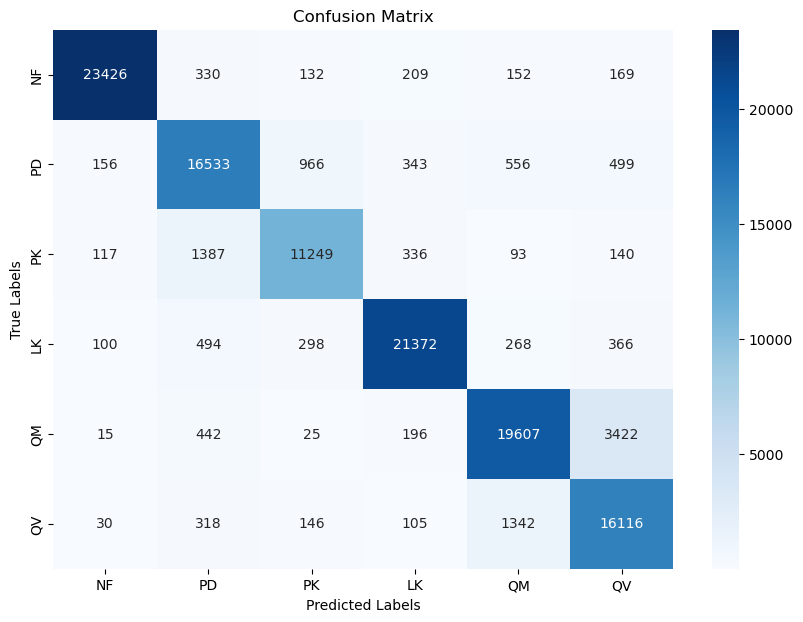

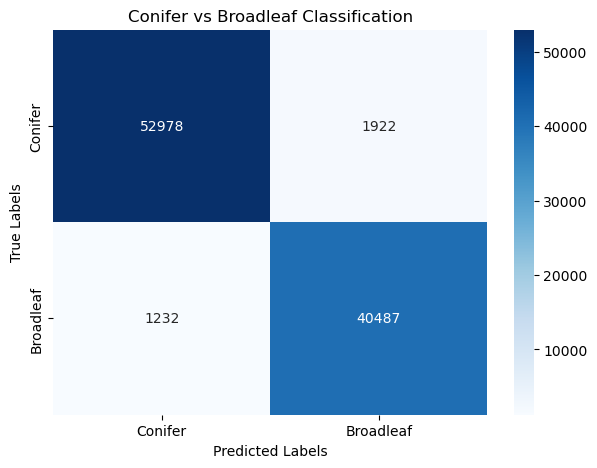

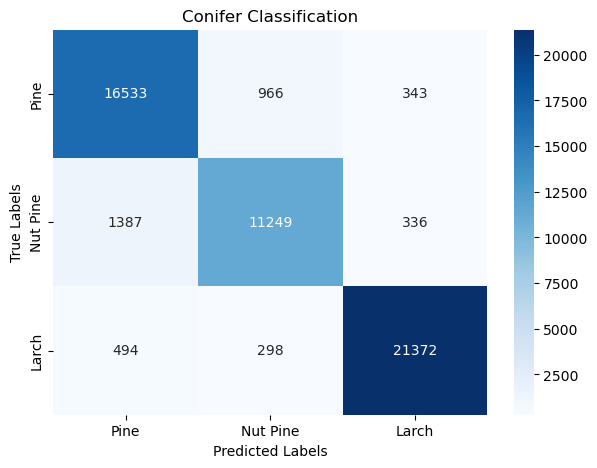

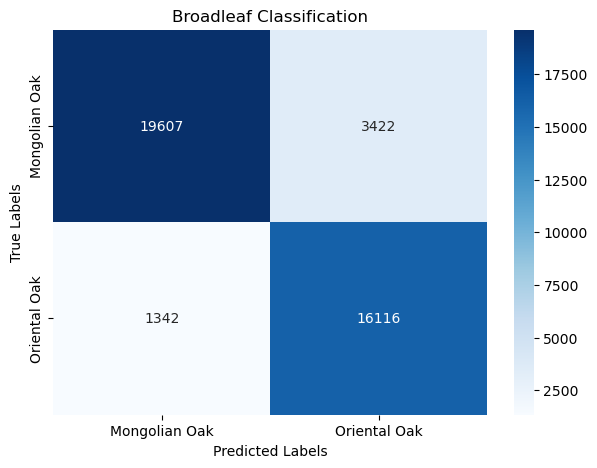


validation data


Evaluation Progress: 100%|██████████████████████████████████| 940/940 [00:05<00:00, 158.33it/s]


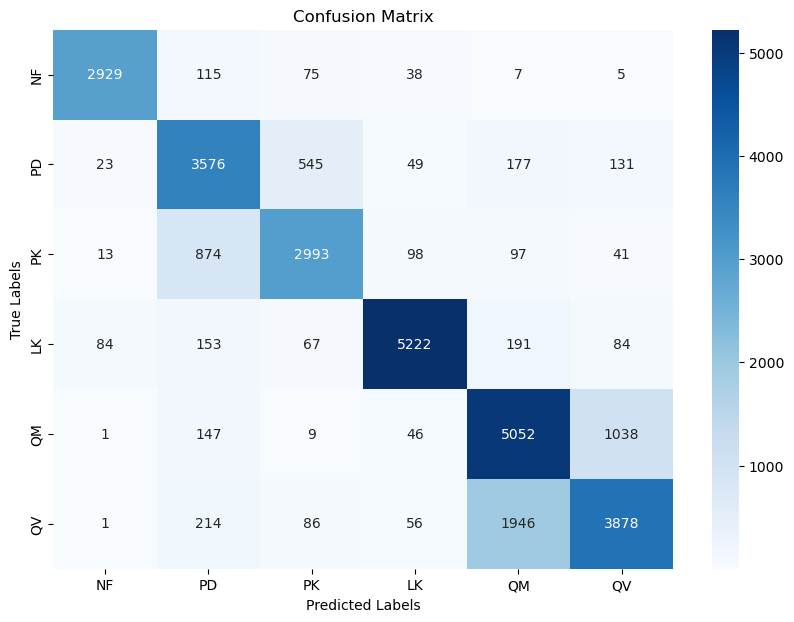

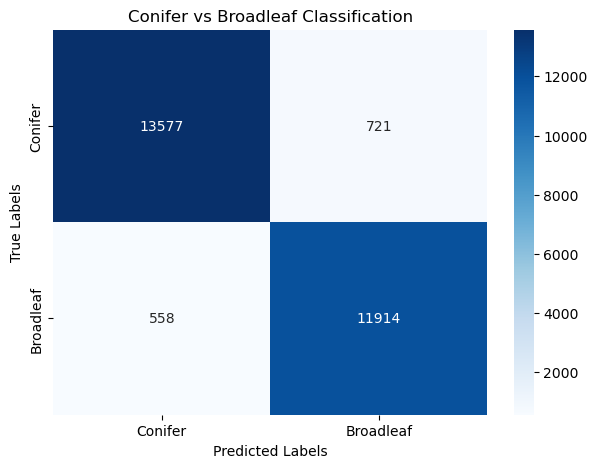

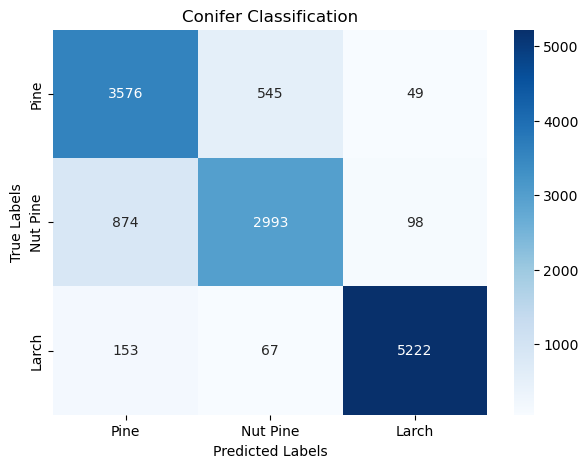

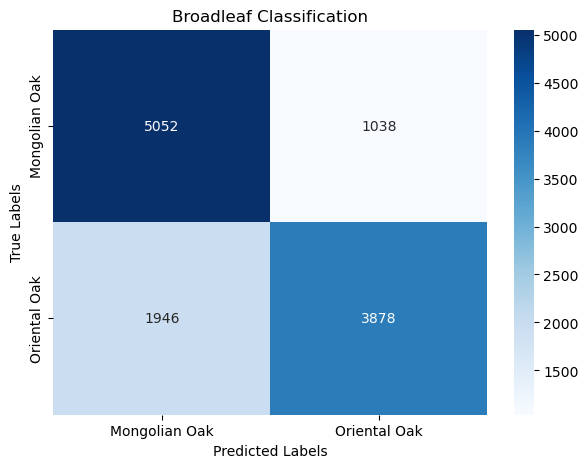

,precision,recall,f1-score,support,Category
NF,0.960013,0.924266,0.941801,3169.000000,Overall
PD,0.704076,0.794490,0.746555,4501.000000,Overall
PK,0.792848,0.727162,0.758586,4116.000000,Overall
LK,0.947903,0.900190,0.923431,5801.000000,Overall
QM,0.676305,0.802797,0.734142,6293.000000,Overall
QV,0.749082,0.627407,0.682867,6181.000000,Overall
accuracy,0.786734,0.786734,0.786734,0.786734,Overall
macro avg,0.805038,0.796052,0.797897,30061.000000,Overall
weighted avg,0.793704,0.786734,0.787224,30061.000000,Overall
Conifer,0.960524,0.949573,0.955017,14298.000000,Conifer vs Broadleaf


In [31]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"transformer_t_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [32]:
# ✅ 메모리 정리
del model,train_dataset, val_dataset, train_loader, val_loader
torch.cuda.empty_cache()

## Using Bands, Time, Space